In [1]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import matplotlib.font_manager as fm
from matplotlib import font_manager, rc
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from numpy import dot 
from numpy.linalg import norm
from libpysal.weights.contiguity import Queen
import splot
from esda.moran import Moran
from splot.esda import moran_scatterplot
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import stats
from scipy.stats import kurtosis
import os
import copy
import gwpca

mpl.rcParams['axes.unicode_minus'] = False
warnings.simplefilter('ignore')

font_path = r'C:/Users/user/NanumFontSetup_TTF_ALL/NanumGothic.ttf'
font_name = font_manager.FontProperties(fname=font_path, size=18).get_name()
rc('font',family=font_name)

# 1. Data Load

In [2]:
data_path = '../data/Dataset' 
os.listdir(data_path)

['fixed_dataset(매출건수).csv',
 'fixed_dataset(자동차유지,10퍼센트절사평균).csv',
 'fixed_dataset(자동차제거,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지).csv',
 'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv',
 'fixed_dataset(자동차제거,매출raw,null유지).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1126).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,1201).csv',
 'fixed_dataset(자동차제거,매출raw,null유지,원래연면적,버퍼점포밀도,1202).csv',
 'fixed_dataset.csv',
 'fixed_dataset_1105.csv',
 'fixed_dataset_1214.csv']

In [3]:
# 1. 매출 log, null 유지
data = pd.read_csv(os.path.join(data_path,'fixed_dataset_1214.csv'),encoding='euc-kr')

# 2. 자동차제거,매출log,null유지,절사평균
# data = pd.read_csv(os.path.join(data_path,'fixed_dataset(자동차제거,매출log,null유지,절사평균).csv'),encoding='euc-kr')
data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,서비스업종다양성,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,1.609438,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.127535,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,2.029155,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.364045,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.289920,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161 entries, 0 to 160
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               161 non-null    int64  
 1   BAS_AR               161 non-null    float64
 2   도로길이고려_전체통합도         161 non-null    float64
 3   도로길이고려_국부통합도_R3      161 non-null    float64
 4   기초구역평균_전체통합도         161 non-null    float64
 5   기초구역평균_국부통합도_R3      161 non-null    float64
 6   도로율                  161 non-null    float64
 7   평균 도로 길이             161 non-null    float64
 8   아파트시세변화_차분평균         161 non-null    float64
 9   평균영업기간               158 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             160 non-null    float64
 12  평균최근접정류장거리           160 non-null    float64
 13  건물노후도                161 non-null    float64
 14  공동주택 비율              161 non-null    float64
 15  근린생활시설 비율            161 non-null    flo

## 1.1 결측치 확인

In [5]:
data.isnull().sum()

BAS_ID                  0
BAS_AR                  0
도로길이고려_전체통합도            0
도로길이고려_국부통합도_R3         0
기초구역평균_전체통합도            0
기초구역평균_국부통합도_R3         0
도로율                     0
평균 도로 길이                0
아파트시세변화_차분평균            0
평균영업기간                  3
평균폐업기간                 10
평균최근접역거리                1
평균최근접정류장거리              1
건물노후도                   0
공동주택 비율                 0
근린생활시설 비율               0
단독주택 비율                 0
아파트 가구수                 0
외식업매출월평균변화량             4
서비스업매출월평균변화량            3
소매업매출월평균변화량             5
외식업매출비율                 8
서비스업매출비율                5
소매업매출비율                 5
외식업종다양성                 1
서비스업종다양성                1
소매업종다양성                 1
상가밀도                    1
주중 / 주말                 0
06 to 18 / 18 to 06     0
개별공시지가 변화 차분평균          0
(주거인구+직장인구) / 유동인구      0
주거인구/직장인구               0
10_30 / 40_60           0
점포밀도                    1
dtype: int64

### 1.1.1 평균운영기간, 평균폐업기간
- 영업기간, 폐업기간 둘 다 없을 경우 제거
- 영업기간은 있지만 폐업기간이 없을 경우 영업기간으로 대체
- 점포밀도가 무한대인 row 제거

In [6]:
data[data['평균폐업기간'].isnull()][['BAS_ID','평균영업기간','평균폐업기간','점포밀도']]

,BAS_ID,평균영업기간,평균폐업기간,점포밀도
22,21322,201.466149,NaN,2.666667
27,21327,89.858108,NaN,12.000000
39,21339,82.104355,NaN,0.000000
72,21372,NaN,NaN,28.500000
73,21373,252.747147,NaN,26.633333
75,21375,NaN,NaN,2.000000
81,21381,183.029083,NaN,16.920000
86,21386,132.306618,NaN,10.750000
159,21459,165.177930,NaN,2.666667
160,21460,NaN,NaN,NaN


In [7]:
# 제거할 row 정의 및 제거

drop_index = list(data[data['평균폐업기간'].isnull()].index)

clean_data = data.drop(drop_index,axis=0).reset_index(drop=True)

In [8]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   BAS_ID               151 non-null    int64  
 1   BAS_AR               151 non-null    float64
 2   도로길이고려_전체통합도         151 non-null    float64
 3   도로길이고려_국부통합도_R3      151 non-null    float64
 4   기초구역평균_전체통합도         151 non-null    float64
 5   기초구역평균_국부통합도_R3      151 non-null    float64
 6   도로율                  151 non-null    float64
 7   평균 도로 길이             151 non-null    float64
 8   아파트시세변화_차분평균         151 non-null    float64
 9   평균영업기간               151 non-null    float64
 10  평균폐업기간               151 non-null    float64
 11  평균최근접역거리             151 non-null    float64
 12  평균최근접정류장거리           151 non-null    float64
 13  건물노후도                151 non-null    float64
 14  공동주택 비율              151 non-null    float64
 15  근린생활시설 비율            151 non-null    flo

In [9]:
condition = clean_data['외식업매출월평균변화량'].isnull() | clean_data['소매업매출월평균변화량'].isnull() 
clean_data[condition].loc[:,['BAS_ID','외식업매출월평균변화량','서비스업매출월평균변화량','소매업매출월평균변화량']]

,BAS_ID,외식업매출월평균변화량,서비스업매출월평균변화량,소매업매출월평균변화량
103,21411,NaN,-20473.33684,-423603.6429


In [10]:
clean_data.fillna(0,inplace=True)

In [11]:
# null값은 없다.
clean_data.isnull().sum()

BAS_ID                 0
BAS_AR                 0
도로길이고려_전체통합도           0
도로길이고려_국부통합도_R3        0
기초구역평균_전체통합도           0
기초구역평균_국부통합도_R3        0
도로율                    0
평균 도로 길이               0
아파트시세변화_차분평균           0
평균영업기간                 0
평균폐업기간                 0
평균최근접역거리               0
평균최근접정류장거리             0
건물노후도                  0
공동주택 비율                0
근린생활시설 비율              0
단독주택 비율                0
아파트 가구수                0
외식업매출월평균변화량            0
서비스업매출월평균변화량           0
소매업매출월평균변화량            0
외식업매출비율                0
서비스업매출비율               0
소매업매출비율                0
외식업종다양성                0
서비스업종다양성               0
소매업종다양성                0
상가밀도                   0
주중 / 주말                0
06 to 18 / 18 to 06    0
개별공시지가 변화 차분평균         0
(주거인구+직장인구) / 유동인구     0
주거인구/직장인구              0
10_30 / 40_60          0
점포밀도                   0
dtype: int64

## 1.2 geometry 정보 로딩

In [12]:
basis_area= gpd.read_file('../data/전처리 파일/부평구_기초구역_5181/부평구_기초구역_4326.shp')
basis_area.head()

,BAS_AR,BAS_ID,BAS_MGT_SN,CTP_KOR_NM,MVMN_DE,MVMN_RESN,NTFC_DE,OPERT_DE,SIG_CD,SIG_KOR_NM,center_x,center_y,geometry
0,2.648838,21459,2823700025,인천광역시,None,None,20121221,None,28237,부평구,126.742914,37.474121,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,0.156212,21384,2823700061,인천광역시,None,None,20121221,None,28237,부평구,126.708049,37.489905,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,0.076024,21403,2823700058,인천광역시,None,None,20121221,None,28237,부평구,126.732706,37.489535,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,0.527205,21447,2823700035,인천광역시,None,None,20121221,None,28237,부평구,126.694834,37.482046,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,0.073898,21421,2823700036,인천광역시,None,None,20121221,None,28237,부평구,126.737058,37.484080,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."


In [13]:
use_basis_area = basis_area[['BAS_ID','geometry']]
use_basis_area

,BAS_ID,geometry
0,21459,"POLYGON ((126.73590 37.48296, 126.73597 37.482..."
1,21384,"POLYGON ((126.70977 37.49105, 126.70987 37.491..."
2,21403,"POLYGON ((126.73383 37.48969, 126.73431 37.489..."
3,21447,"POLYGON ((126.69892 37.48537, 126.69960 37.485..."
4,21421,"POLYGON ((126.73785 37.48219, 126.73772 37.482..."
...,...,...
156,21423,"POLYGON ((126.73624 37.48294, 126.73641 37.482..."
157,21441,"POLYGON ((126.70483 37.48126, 126.70465 37.481..."
158,21446,"POLYGON ((126.70290 37.47138, 126.70289 37.471..."
159,21453,"POLYGON ((126.70070 37.46956, 126.70069 37.469..."


In [14]:
use_basis_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
clean_data['BAS_ID'] = clean_data['BAS_ID'].astype(str) # string 티입으로 변환
clean_data = clean_data.merge(use_basis_area,how='left',right_on='BAS_ID',left_on='BAS_ID').sort_values(by='BAS_ID')
clean_data.head()

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,소매업종다양성,상가밀도,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry
0,21300,0.743330,617.130076,7987.604945,0.060037,0.907932,7.332336,119.253463,0.000,163.106482,...,2.390980,86.099041,2.342449,2.695669,31337.73585,0.268398,0.149563,0.406896,7.046875,"POLYGON ((126.69032 37.52345, 126.69084 37.523..."
1,21301,0.121045,221.397046,2876.534944,0.069661,0.938454,30.948119,211.340833,305.909,156.249615,...,1.985080,346.978396,2.315147,2.280277,344640.00000,0.254881,0.667946,0.439757,11.523810,"POLYGON ((126.69791 37.52246, 126.69791 37.522..."
2,21302,0.175777,341.252878,4162.583064,0.087372,1.084619,25.546905,214.144187,0.000,111.950730,...,1.314799,876.110071,2.064957,2.339853,174949.46240,0.220317,0.899425,0.508371,143.584416,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."
3,21303,0.270679,475.038010,6080.093135,0.084712,1.079401,15.517121,105.011320,912.500,153.728003,...,2.064017,232.748015,2.273528,2.246297,97041.79104,0.108296,6.308614,0.441902,36.111111,"POLYGON ((126.70215 37.51767, 126.70204 37.517..."
4,21304,0.073319,273.241567,3575.514233,0.092931,1.107098,32.713927,134.361765,369.231,177.329451,...,2.379112,2495.942389,2.016228,2.004099,166589.33650,0.212989,1.959390,0.479893,113.836066,"POLYGON ((126.70466 37.52105, 126.70466 37.521..."


In [16]:
center = gpd.GeoDataFrame(clean_data).centroid

clean_data['x'] = center.x
clean_data['y'] = center.y

clean_data.iloc[:,-3:]

,geometry,x,y
0,"POLYGON ((126.69032 37.52345, 126.69084 37.523...",126.689135,37.518708
1,"POLYGON ((126.69791 37.52246, 126.69791 37.522...",126.695459,37.522417
2,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.701342,37.522339
3,"POLYGON ((126.70215 37.51767, 126.70204 37.517...",126.698730,37.518981
4,"POLYGON ((126.70466 37.52105, 126.70466 37.521...",126.703419,37.519319
...,...,...,...
146,"POLYGON ((126.70003 37.46834, 126.69995 37.468...",126.695939,37.469443
147,"POLYGON ((126.69459 37.47098, 126.69442 37.470...",126.692372,37.471208
148,"POLYGON ((126.72120 37.48069, 126.72130 37.480...",126.723687,37.476074
149,"POLYGON ((126.75185 37.48111, 126.75174 37.480...",126.749377,37.478546


## 1.3 데이터 분포 확인

In [17]:
ind_var = clean_data.drop([col for col in list(clean_data) if '변화' in col],axis=1)
ind_var = ind_var.drop(['BAS_ID','BAS_AR','x','y','건물노후도','geometry','평균영업기간','평균폐업기간'],axis=1)

In [18]:
ind_var.columns

Index(['도로길이고려_전체통합도', '도로길이고려_국부통합도_R3', '기초구역평균_전체통합도', '기초구역평균_국부통합도_R3',
       '도로율', '평균 도로 길이', '평균최근접역거리', '평균최근접정류장거리', '공동주택 비율', '근린생활시설 비율',
       '단독주택 비율', '아파트 가구수', '외식업매출비율', '서비스업매출비율', '소매업매출비율', '외식업종다양성',
       '서비스업종다양성', '소매업종다양성', '상가밀도', '주중 / 주말', '06 to 18 / 18 to 06',
       '(주거인구+직장인구) / 유동인구', '주거인구/직장인구', '10_30 / 40_60', '점포밀도'],
      dtype='object')

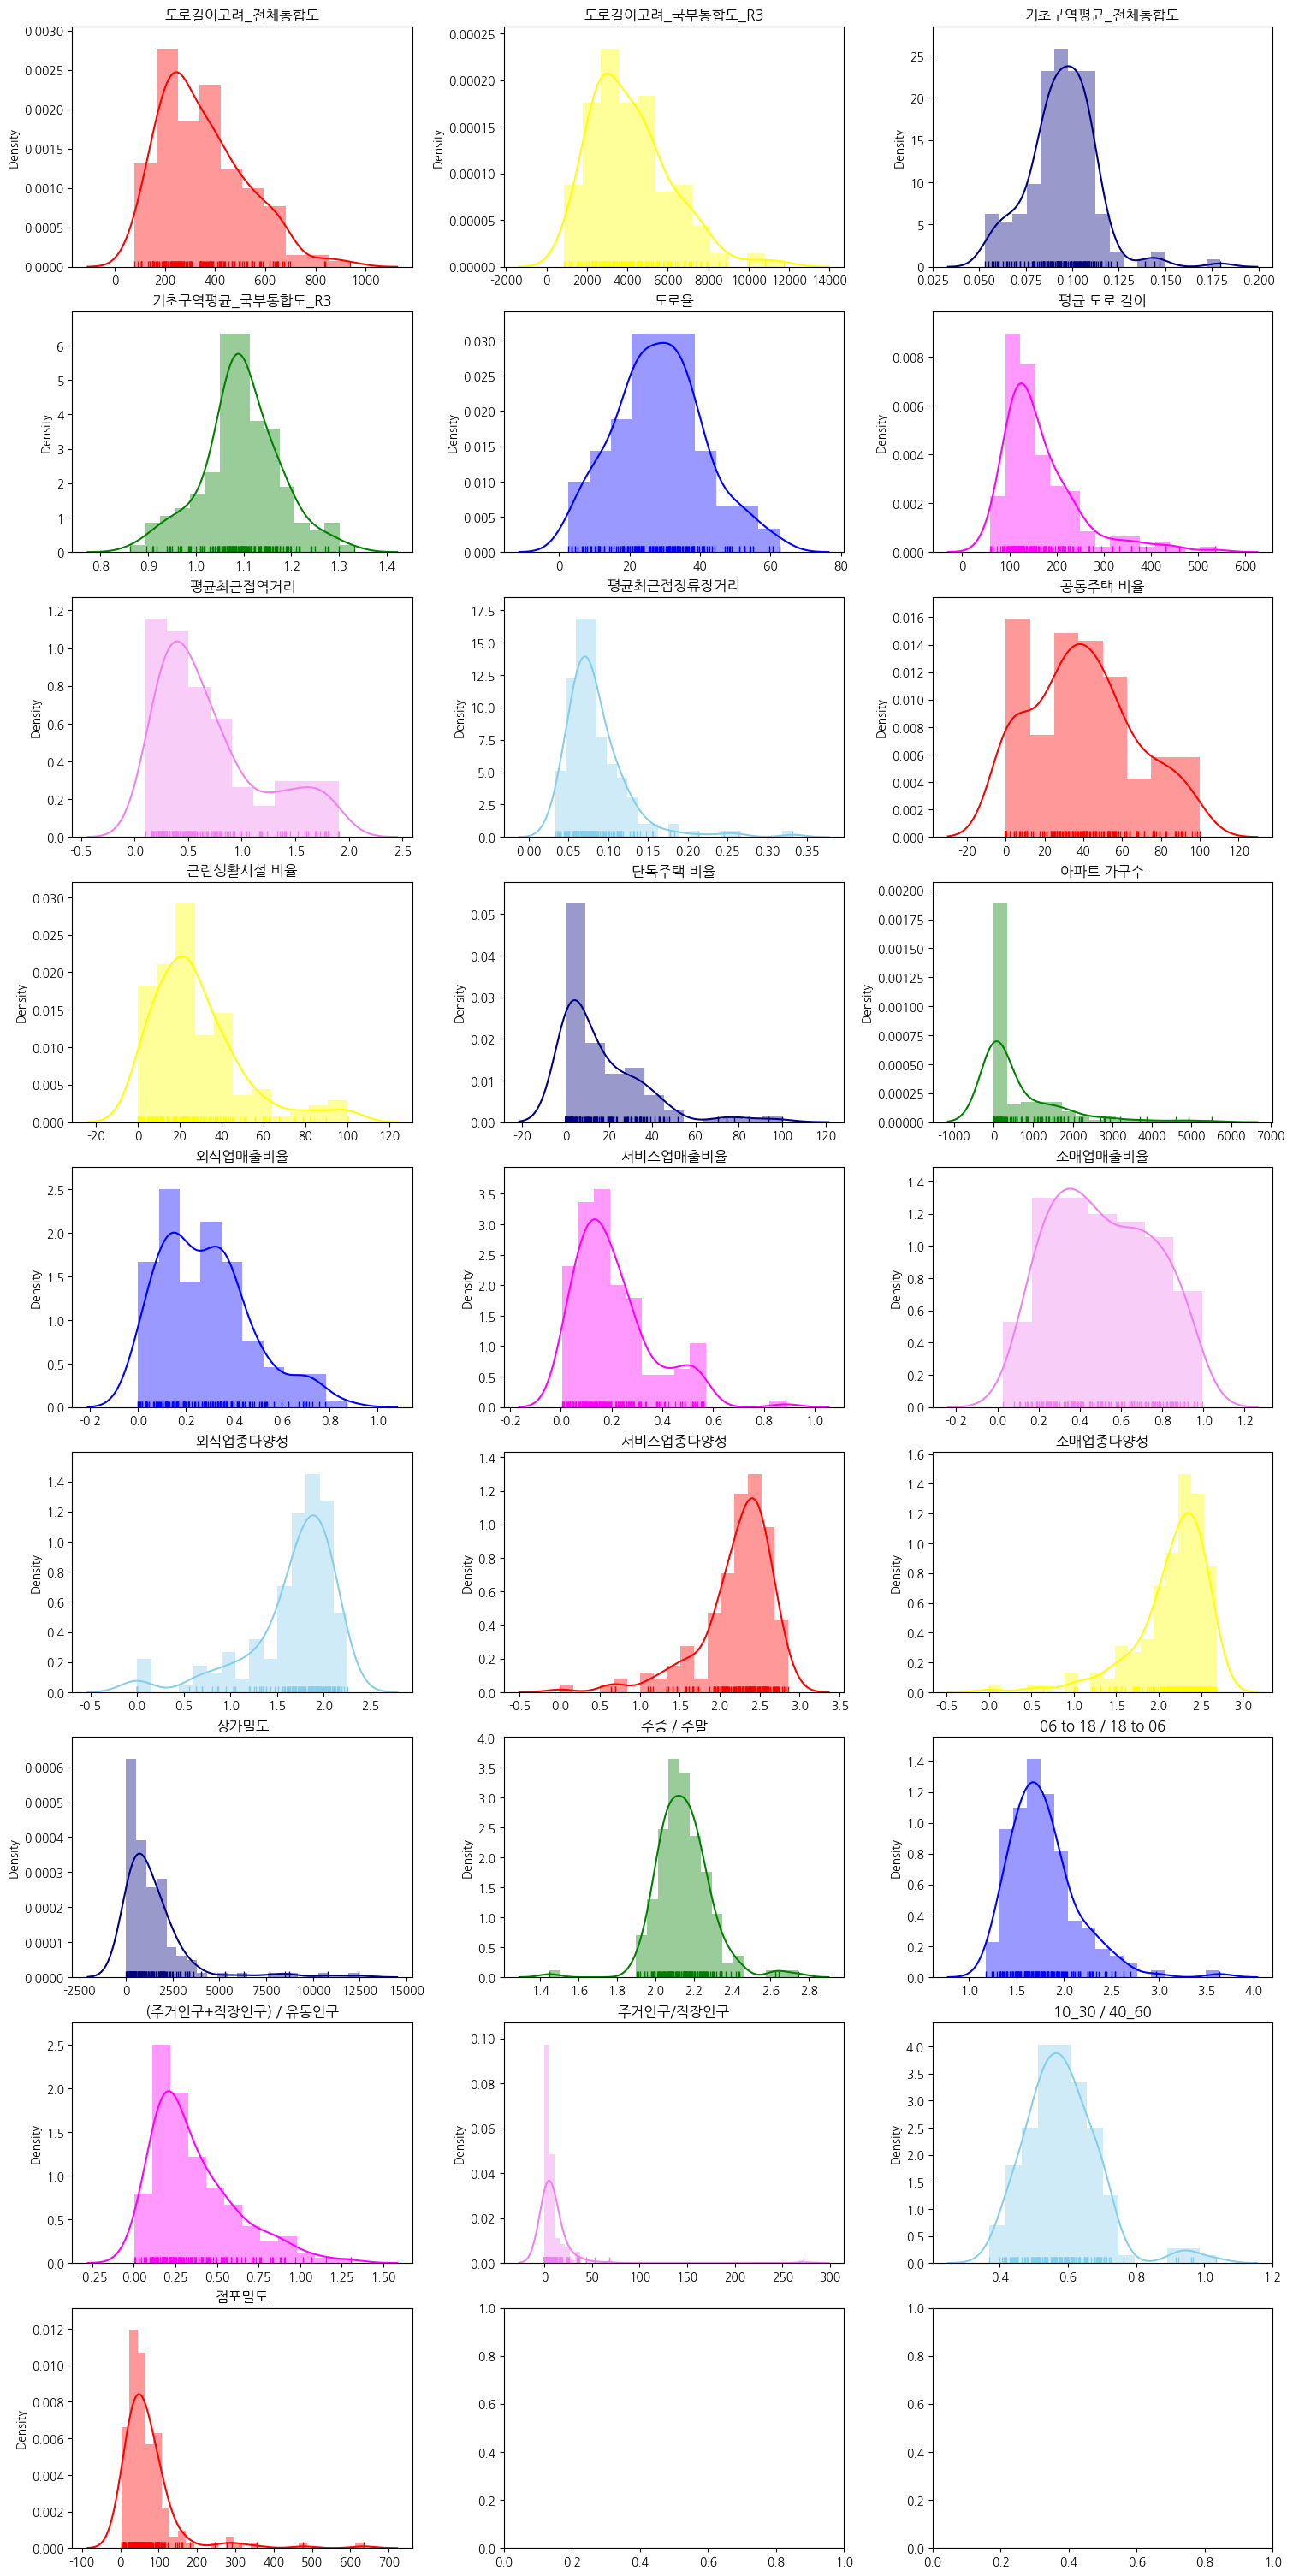

In [21]:
col_list = list(ind_var)
nrows = int(len(col_list)/3)+1
ncols = 3

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,30),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(nrows):
    for j in range(ncols):
        if (ncols*i+j) == len(col_list):
            break
        
        sns.distplot(ax=axes[i,j], x=ind_var[col_list[(ncols*i+j)]], kde=True,color=color[(ncols*i+j) % len(color)],rug=True)
        axes[i,j].set_title(col_list[ncols*i+j])
         
plt.show()

# 2. 공간상관성 검증
- H0 : 군집이 존재하지 않는다. 즉, 모든 구역이 Randomness를 가진다.(AutoCorrelation이 없다.)
- 유의 수준 : 0.05
- 검정통계량 : Morans'I

In [24]:

gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = clean_data.loc[:,'평균폐업기간']
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=9999)
moran.I

0.18560315065384791

- HH : the high value area is surrounded by high value
- LH : the low value area is surrounded by high value
- HL : the high value area is surrounded by low value
- LL : the low value area is surrounded by low vlaue

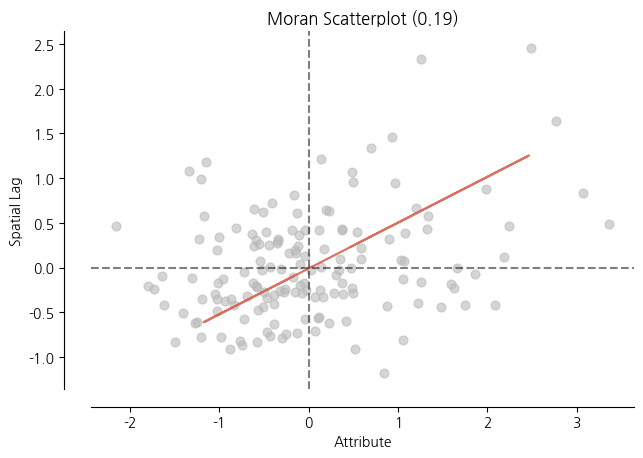

In [25]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

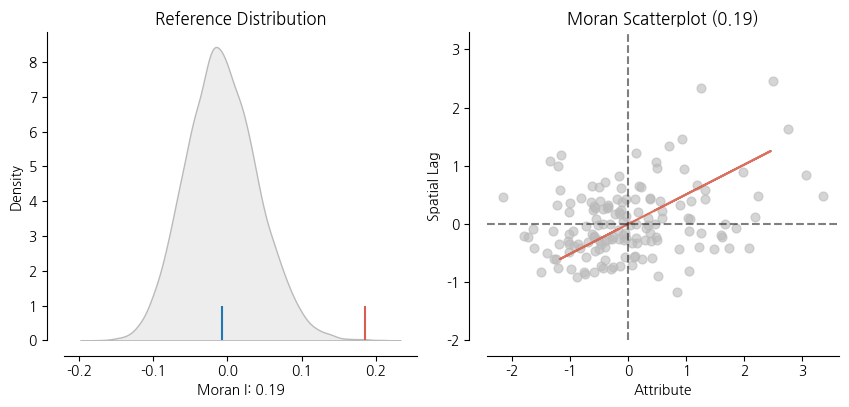

In [26]:
from splot.esda import plot_moran
plot_moran(moran, zstandard=True, figsize=(10,4))
plt.show()

In [27]:
print('{:.5f}'.format(moran.p_sim))

0.00060


- p-value가 위와 같으므로 유의수준 5%이내에서 전역적으로 보았을 때 군집이 존재하다고 이야기 할수 있다.

## 2.1 독립변수별 Moran's I 검정

In [28]:
spatial_corr = []

for col in list(ind_var):
    temp_y = clean_data.loc[:,col]
    temp_w = Queen.from_dataframe(gdf)

    moran = Moran(temp_y, temp_w,permutations=999)
    print('='*30)
    print('column : '+col)
    print('Moran\'s I : {:5f}'.format(moran.I))
    print('p-value : {:.5f}'.format(moran.p_sim))
    if moran.p_sim < 0.05:
        spatial_corr.append(col)

column : 도로길이고려_전체통합도
Moran's I : 0.224195
p-value : 0.00100
column : 도로길이고려_국부통합도_R3
Moran's I : 0.157102
p-value : 0.00200
column : 기초구역평균_전체통합도
Moran's I : 0.600795
p-value : 0.00100
column : 기초구역평균_국부통합도_R3
Moran's I : 0.283738
p-value : 0.00100
column : 도로율
Moran's I : 0.332320
p-value : 0.00100
column : 평균 도로 길이
Moran's I : 0.285828
p-value : 0.00100
column : 평균최근접역거리
Moran's I : 0.818827
p-value : 0.00100
column : 평균최근접정류장거리
Moran's I : 0.220024
p-value : 0.00100
column : 공동주택 비율
Moran's I : 0.083504
p-value : 0.03100
column : 근린생활시설 비율
Moran's I : 0.021476
p-value : 0.26700
column : 단독주택 비율
Moran's I : 0.228289
p-value : 0.00100
column : 아파트 가구수
Moran's I : 0.354305
p-value : 0.00100
column : 외식업매출비율
Moran's I : 0.021578
p-value : 0.26500
column : 서비스업매출비율
Moran's I : 0.079839
p-value : 0.03700
column : 소매업매출비율
Moran's I : 0.101795
p-value : 0.02700
column : 외식업종다양성
Moran's I : 0.098186
p-value : 0.02400
column : 서비스업종다양성
Moran's I : 0.213414
p-value : 0.00200
column : 소매업종다양성


# 3. LISA 검정
- 왜 국지적 모델(GWR)을 써야하는가?
- Morans'I를 통해서 공간적 의존성은 확인할 수 있으나 공간적 이질성은 확인할 수가 없다.
- 공간적 의존성 : 공간상의 한 지점에서 측정된 현상이 다른 지점에서의 측정값과 서로 관련이 있을 때 나타난다.
- 공간적 이질성 : 각 지점이나 지역에 내재된 고유성에서 발생하게 되는 자료의 지리적 변이나 통계적 특성의 차이를 말한다.
- LISA 검정을 통해서 공간적 이질성이 존재하는지 확인해본다.
- H0 : 특정지역별로 공간적 군집이 형성되지 않는다.
- 유의 수준 : 0.05

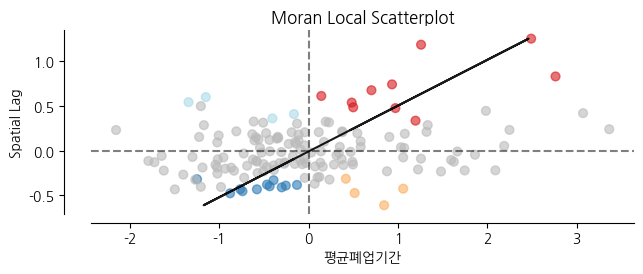

In [29]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local

# calculate Moran_Local and plot
lisa = Moran_Local(y, w)
fig, ax = moran_scatterplot(lisa, p=0.05,aspect_equal = True)
ax.set_xlabel('평균폐업기간')
ax.set_ylabel('Spatial Lag')
plt.show()

In [30]:
lisa.sim.shape
# 158개 row를 999번 시행하여 값 생성

(999, 151)

In [31]:
sig = lisa.p_sim < 0.05
sig.sum()

29

In [32]:
hotspots = lisa.q==1 * sig
hotspots.sum()

10

In [33]:
# HH Area
clean_data[hotspots]

,BAS_ID,BAS_AR,도로길이고려_전체통합도,도로길이고려_국부통합도_R3,기초구역평균_전체통합도,기초구역평균_국부통합도_R3,도로율,평균 도로 길이,아파트시세변화_차분평균,평균영업기간,...,주중 / 주말,06 to 18 / 18 to 06,개별공시지가 변화 차분평균,(주거인구+직장인구) / 유동인구,주거인구/직장인구,10_30 / 40_60,점포밀도,geometry,x,y
5,21305,0.098059,523.710848,6145.133162,0.095792,1.100614,38.069916,106.077128,0.00000,177.936443,...,2.048316,1.997069,69414.52880,0.224666,2.090174,0.412279,101.358079,"POLYGON ((126.70432 37.51753, 126.70426 37.517...",126.703004,37.515329
6,21306,0.284578,649.381963,7939.781286,0.087015,1.078935,12.802792,117.955382,1753.75000,150.927607,...,1.953813,2.429456,76053.06346,1.304734,24.640398,0.368579,52.237288,"POLYGON ((126.70215 37.51767, 126.70214 37.517...",126.697205,37.515679
7,21307,0.616604,589.273284,7121.372418,0.089115,1.069964,6.382154,119.324019,458.70125,124.118451,...,1.944366,2.252227,56452.17391,0.911136,8.710714,0.400088,49.262821,"POLYGON ((126.70164 37.51321, 126.70165 37.513...",126.693100,37.512529
8,21308,0.229900,421.903482,5071.581658,0.093441,1.153545,9.134493,156.407455,0.00000,196.324360,...,2.262532,1.770196,67064.35185,0.970011,9.507922,0.511661,21.785714,"POLYGON ((126.69275 37.51095, 126.69369 37.510...",126.694636,37.509724
9,21309,0.102131,342.128741,4248.872704,0.098518,1.144899,33.748921,149.365524,1716.71400,136.442782,...,2.146131,1.985019,77593.49776,0.242858,4.188744,0.474761,111.666667,"POLYGON ((126.70394 37.51300, 126.70393 37.512...",126.702572,37.510880
64,21367,0.228448,433.242790,5042.136816,0.094212,1.099477,23.912363,125.875000,168.32500,177.378043,...,2.244106,1.861148,86329.74684,1.018047,26.379078,0.518825,18.473684,"POLYGON ((126.69990 37.50892, 126.69990 37.508...",126.696109,37.507611
65,21368,0.218311,302.074763,3370.850035,0.088329,1.013514,5.180353,79.951000,-172.09800,166.065012,...,2.227330,1.885386,98608.75000,0.309573,7.710605,0.509767,39.752577,"POLYGON ((126.69505 37.50601, 126.69556 37.505...",126.692740,37.505831
68,21371,0.276454,254.133267,2766.003388,0.086290,0.941897,11.016673,171.059500,116.79080,155.173618,...,2.217672,1.762641,52661.15702,0.318259,5.566451,0.536672,55.027027,"POLYGON ((126.69948 37.50457, 126.69952 37.504...",126.695205,37.502867
134,21442,0.114856,289.426135,4282.257877,0.071866,1.114438,28.990773,153.711476,-16.76200,160.228043,...,2.200554,1.901046,36619.04762,0.435738,10.770142,0.492171,42.360000,"POLYGON ((126.70038 37.47962, 126.70000 37.479...",126.698235,37.479768
140,21448,0.170218,204.084763,3832.016965,0.058481,1.069951,35.189054,219.372933,0.00000,120.716836,...,2.301674,2.502342,54211.17647,0.105341,0.011076,0.417504,20.265957,"POLYGON ((126.69327 37.47743, 126.69321 37.477...",126.690629,37.476359


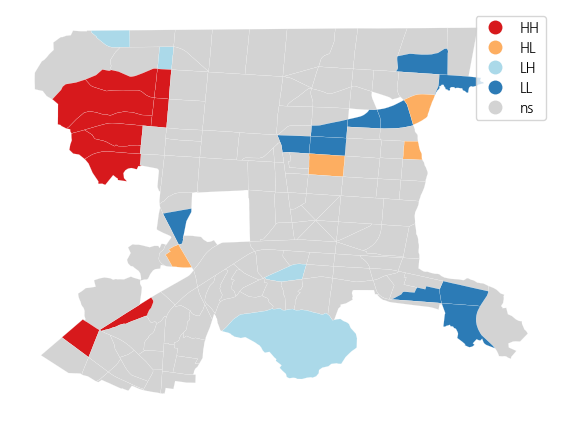

In [34]:
from splot.esda import lisa_cluster

gdf = gpd.GeoDataFrame(gdf)

lisa_cluster(lisa, gdf, p=0.05, figsize = (7,7))
plt.show()

- 총 14곳의 hotspot이 존재한다. 따라서 공간적 이질성을 가진다고 판단할 수 있고, GWR 모델을 고려해야 한다.

# 4. OLS

## 4.1 독립변수, 종속변수 설정

In [35]:
import statsmodels.api as sm

In [36]:
# X = clean_data.iloc[:,ind_var_col]
X = sm.add_constant(ind_var)
y = clean_data.loc[:,'평균폐업기간'].values
ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     2.236
Date:                Wed, 29 Dec 2021   Prob (F-statistic):            0.00199
Time:                        14:49:18   Log-Likelihood:                -746.03
No. Observations:                 151   AIC:                             1544.
Df Residuals:                     125   BIC:                             1623.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.393e+09   6.73e+09     -0.207      0.836   -1.47e+10    1.19e+10
도로길이고려_전체통합도           -0.0102      0.106     -0.097      0.923      -0.219       0.199
도로길이고려_국부통합도_R3         0.0047      0.009      0.540      0.590      -0.012       0.022
기초구역평균_전체통합도          153.7038    431.058      0.357      0.722    -699.414    1006.822
기초구역평균_국부통합도_R3       -27.8221     63.589     -0.438      0.662    -153.672      98.028
도로율                    -1.0316      0.376     -2.743      0.007      -1.776      -0.287
평균 도로 길이               -0.1662      0.050     -3.302      0.001      -0.266      -0.067
평균최근접역거리                5.1757      8.522      0.607      0.545     -11.690      22.042
평균최근접정류장거리           -144.5456    102.610     -1.409      0.161    -347.623      58.532
공동주택 비율                -0.2016      0.207     -0.975      0.331      -0.611       0.208
근린생활시설 비율              -0.1692      0.203     -0.832      0.407      -0.572       0.233
단독주택 비율                -0.3103      0.232     -1.335      0.184      -0.770       0.150
아파트 가구수                -0.0081      0.004     -1.913      0.058      -0.016       0.000
외식업매출비율              1.393e+09   6.73e+09      0.207      0.836   -1.19e+10    1.47e+10
서비스업매출비율             1.393e+09   6.73e+09      0.207      0.836   -1.19e+10    1.47e+10
소매업매출비율              1.393e+09   6.73e+09      0.207      0.836   -1.19e+10    1.47e+10
외식업종다양성                 5.3155      9.714      0.547      0.585     -13.909      24.540
서비스업종다양성                0.0224     10.374      0.002      0.998     -20.508      20.553
소매업종다양성                -9.5630     11.173     -0.856      0.394     -31.676      12.550
상가밀도                    0.0031      0.004      0.792      0.430      -0.005       0.011
주중 / 주말                85.0097     29.780      2.855      0.005      26.071     143.948
06 to 18 / 18 to 06    -0.2164     15.910     -0.014      0.989     -31.705      31.272
(주거인구+직장인구) / 유동인구     32.9022     17.200      1.913      0.058      -1.138      66.942
주거인구/직장인구               0.0108      0.156      0.069      0.945      -0.298       0.320
10_30 / 40_60         -68.1140     56.561     -1.204      0.231    -180.055      43.827
점포밀도                   -0.0425      0.087     -0.490      0.625      -0.214       0.129
==============================================================================
Omnibus:                        9.930   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.027
Skew:                           0.560   Prob(JB):                      0.00665
Kurtosis:                       3.583   Cond. No.                     2.18e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance ma

## 4.2 Modeling

### 4.2.1 다중공선성

In [37]:
def check_vif(dX):
    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(dX.values,i) for i in range(dX.values.shape[1])] 
    vif['features'] = dX.columns
    vif = vif.sort_values("VIF Factor").reset_index(drop=True)
    
    return vif

result = check_vif(ind_var)
result.iloc[-10:,]

,VIF Factor,features
15,65.387859,소매업종다양성
16,89.781678,06 to 18 / 18 to 06
17,110.806541,외식업매출비율
18,123.050952,10_30 / 40_60
19,174.291391,도로길이고려_국부통합도_R3
20,182.533485,도로길이고려_전체통합도
21,184.442184,기초구역평균_전체통합도
22,284.084301,소매업매출비율
23,447.895917,주중 / 주말
24,526.639174,기초구역평균_국부통합도_R3


#### 4.2.1.2 column 제거

In [38]:
def RFE(df):
    flag = True
    next_col = list(df.columns)
    
    while flag:
        local = df.loc[:,next_col]
        result = check_vif(local)

        if len(result[result['VIF Factor'] > 10]) == 0:
            return result # 유일한 탈출 조건
        
#         display(result[-7:])
        next_col = result.iloc[:-1,1].values.tolist()
        
vif_result = RFE(ind_var)
optimal_feature = vif_result['features'].values.tolist()
optimal_feature

['주거인구/직장인구',
 '아파트 가구수',
 '단독주택 비율',
 '서비스업매출비율',
 '외식업매출비율',
 '근린생활시설 비율',
 '평균최근접역거리',
 '(주거인구+직장인구) / 유동인구',
 '공동주택 비율',
 '평균 도로 길이',
 '도로길이고려_전체통합도',
 '평균최근접정류장거리',
 '점포밀도',
 '도로율',
 '상가밀도']

#### 4.2.1.3 Remodeling


In [39]:
X = clean_data.loc[:,optimal_feature].values
X = sm.add_constant(X)
y = clean_data.loc[:,'평균폐업기간'].values

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.545
Date:                Wed, 29 Dec 2021   Prob (F-statistic):            0.00231
Time:                        14:49:38   Log-Likelihood:                -755.13
No. Observations:                 151   AIC:                             1542.
Df Residuals:                     135   BIC:                             1591.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.7365     26.053      6.093      0.000     107.213     210.260
x1            -0.0089      0.152     -0.059      0.953      -0.310       0.292
x2            -0.0104      0.004     -2.715      0.007      -0.018      -0.003
x3            -0.2420      0.218     -1.109      0.269      -0.674       0.190
x4           -17.5538     21.956     -0.799      0.425     -60.977      25.869
x5            26.3474     17.302      1.523      0.130      -7.872      60.566
x6            -0.1643      0.196     -0.837      0.404      -0.552       0.224
x7             8.6533      7.409      1.168      0.245      -5.999      23.305
x8            31.7466     16.036      1.980      0.050       0.033      63.460
x9            -0.2350      0.204     -1.153      0.251      -0.638       0.168
x10           -0.1024      0.045     -2.250      0.026      -0.192      -0.012
x11            0.0409      0.020      2.052      0.042       0.001       0.080
x12         -143.6026     93.180     -1.541      0.126    -327.884      40.678
x13           -0.0579      0.081     -0.711      0.478      -0.219       0.103
x14           -1.0475      0.349     -3.002      0.003      -1.738      -0.357
x15            0.0008      0.004      0.202      0.840      -0.007       0.008
==============================================================================
Omnibus:                        8.120   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.877
Skew:                           0.506   Prob(JB):                       0.0195
Kurtosis:                       3.477   Cond. No.                     7.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4.2.2 잔차분석
- 회귀모형에 대한 가정(정규성, 등분산성, 독립성)을 충족하는지에 대한 검정, 이상치가 개입하는지에 대한 검정을 하는 절차

In [40]:
import scipy as sp
from scipy import stats

#### 4.2.2.1 잔차 정규성

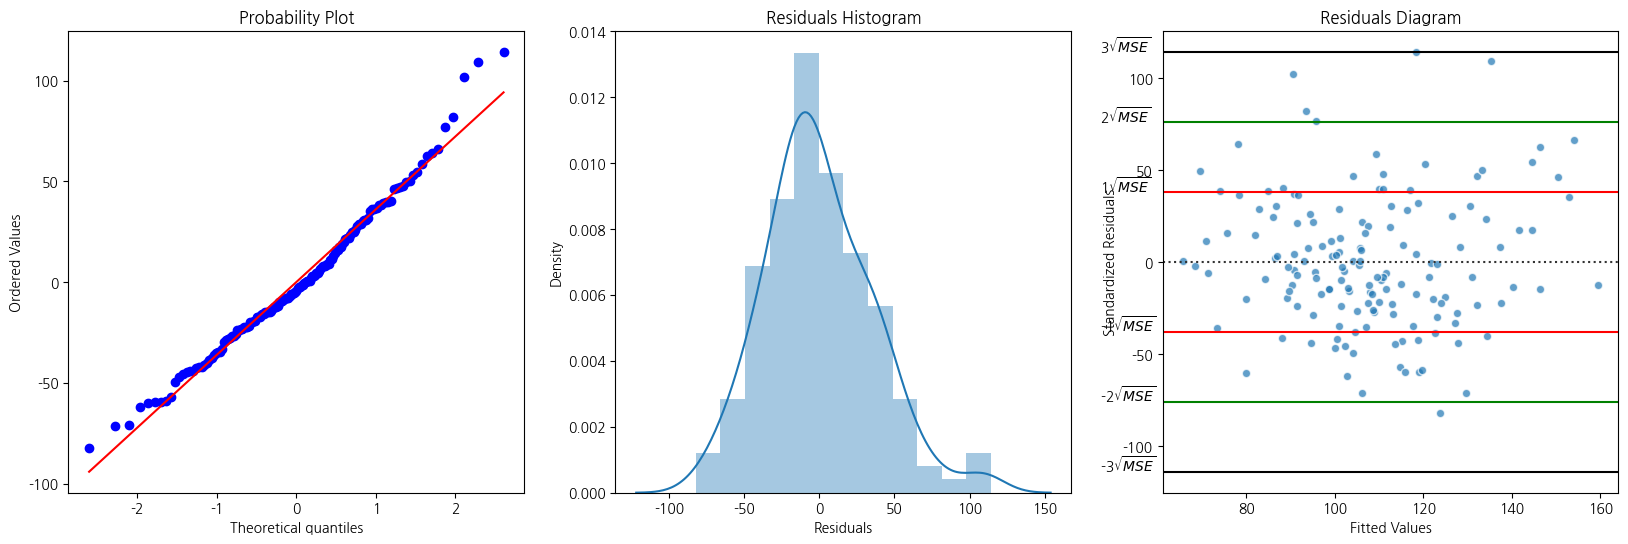

In [41]:
figure, axs = plt.subplots(1,3, figsize = (20,6))

# 잔차 Q-Q  plot
# sm.ProbPlot(fit1.resid).qqplot(line="s",ax=axs[0])
sp.stats.probplot(results.resid, dist='norm', fit=True, plot=axs[0])

# 잔차의 히스토그램
sns.distplot(x = results.resid , ax = axs[1])
axs[1].set_xlabel("Residuals")
axs[1].set_title("Residuals Histogram")

# 잔차도 MSE 라인
yhat = pd.DataFrame(results.fittedvalues)
temp = pd.concat([yhat,clean_data.loc[:,'평균폐업기간']],axis=1)
temp.columns = ['yhat','MEDV']

sns.residplot(x='yhat',y='MEDV',data=temp, scatter_kws = {'edgecolor':"white", "alpha":0.7}, line_kws = {"color":"red"})
MSE_sq = np.sqrt(results.mse_resid) #RMSE

# 잔차도 MSE line
for i, c in enumerate(["red", "green", "black"]):
    axs[2].axhline( (i+1) * MSE_sq, color = c)
    axs[2].axhline( -(i+1) * MSE_sq, color = c)
    
    axs[2].text(47, (i+1) * MSE_sq, f"{i+1}"r'${}\sqrt{MSE}$')
    axs[2].text(47, -(i+1) * MSE_sq, f"-{i+1}"r'${}\sqrt{MSE}$')

axs[2].set_xlabel("Fitted Values")
axs[2].set_ylabel("Standardized Residuals")
axs[2].set_title("Residuals Diagram")

plt.show()

In [42]:
test = stats.shapiro(results.resid)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 귀무가설을 기각할 수 없으므로 정규성을 따른다.

검정통계량 : 0.9819465279579163
p-value : 0.044925469905138016


#### 4.2.2.2 잔차 등분산성
- 종속 변수의 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야 한다.
- 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 이분산성 문제가 발생한다.

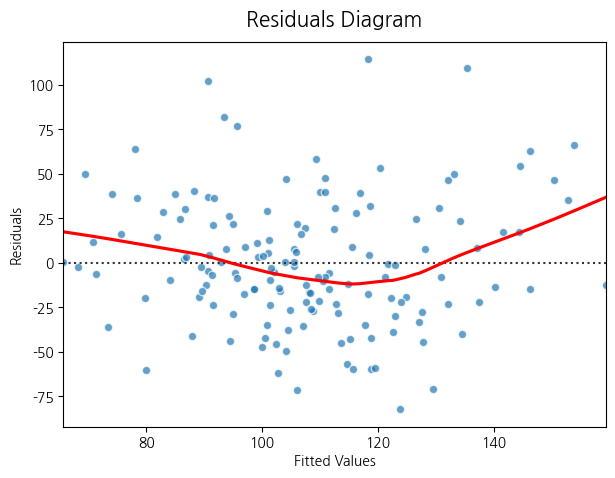

In [43]:
fig = plt.figure(figsize= (7,5))

p = sns.residplot(x = "yhat", y = "MEDV", 
                  data = temp, 
                  scatter_kws = {'edgecolor':"white", "alpha":0.7},
                  lowess = True,
              line_kws = {"color":"red"})

p.set_title("Residuals Diagram", fontsize=15, y=1.02)
p.set(xlabel= "Fitted Values", ylabel = "Residuals")

plt.show()

In [44]:
from sklearn.linear_model import LinearRegression
from scipy.stats import chisqprob


def breusch_pagan_test(x, y):
    '''
    Breusch-Pagan test for heteroskedasticity in a linear regression model:
    H_0 = No heteroskedasticity.
    H_1 = Heteroskedasticity is present.

    Inputs:
    x = a numpy.ndarray containing the predictor variables. Shape = (nSamples, nPredictors).
    y = a 1D numpy.ndarray containing the response variable. Shape = (nSamples, ).

    Outputs a list containing three elements:
    1. the Breusch-Pagan test statistic.
    2. the p-value for the test.
    3. the test result.
    '''

    if y.ndim != 1:
        raise SystemExit('Error: y has more than 1 dimension.')
    if x.shape[0] != y.shape[0]:
        raise SystemExit('Error: the number of samples differs between x and y.')
    else:
        n_samples = y.shape[0]

    # fit an OLS linear model to y using x:
    lm = LinearRegression()
    lm.fit(x, y)

    # calculate the squared errors:
    err = (y - lm.predict(x))**2

    # fit an auxiliary regression to the squared errors:
    # why?: to estimate the variance in err explained by x
    lm.fit(x, err)
    pred_err = lm.predict(x)
    del lm

    # calculate the coefficient of determination:
    ss_tot = sum((err - np.mean(err))**2)
    ss_res = sum((err - pred_err)**2)
    r2 = 1 - (ss_res / ss_tot)
    del err, pred_err, ss_res, ss_tot

    # calculate the Lagrange multiplier:
    LM = n_samples * r2
    del r2

    # calculate p-value. degrees of freedom = number of predictors.
    # this is equivalent to (p - 1) parameter restrictions in Wikipedia entry.
    pval = chisqprob(LM, x.shape[1])

    if pval < 0.01:
        test_result = 'Heteroskedasticity present at 99% CI.'
    elif pval < 0.05:
        test_result = 'Heteroskedasticity present at 95% CI.'
    else:
        test_result = 'No significant heteroskedasticity.'
    return [LM, pval, test_result]

tX = clean_data.loc[:,optimal_feature]
ty = clean_data.loc[:,'평균영업기간']

result = breusch_pagan_test(tX,ty)
print('LM : {}\np-value : {}\ntest_result {}'.format(result[0],result[1],result[2]))

# p-value가 유의수준 0.05보다 크므로 귀무가설을 기각할 수 없다. 따라서 등분산성을 만족한다고 할수 있다.

LM : 10.168214898690469
p-value : 0.8090273892282505
test_result No significant heteroskedasticity.


#### 4.2.2.3 잔차 독립성

In [45]:
from statsmodels.stats.stattools import durbin_watson

print(f"D-W 통계량: {round(durbin_watson(results.resid),3)}")

# 통계량이 1.5~2.5 사이이므로 잔차들이 자기상관성을 가지고 있지 않다. 따라서 독립성을 만족한다.

D-W 통계량: 1.896


#### 4.2.2.4 잔차 Moran's I

In [46]:
gdf = pd.DataFrame(clean_data.loc[:,'geometry'],columns=['geometry'])
# y = clean_data['평균영업기간'].values

y = results.resid
w = Queen.from_dataframe(gdf)

moran = Moran(y, w,permutations=9999)
moran.I

0.04140973296809754

In [47]:
print('{:.5f}'.format(moran.p_sim))

0.15330


### 4.2.3 PCA

In [60]:
# Scaling
dX_scaled = StandardScaler().fit_transform(ind_var.loc[:,optimal_feature].values)
std_df = pd.DataFrame(dX_scaled, index=ind_var.index, columns=optimal_feature)

# PCA
pca = PCA(n_components=len(optimal_feature))
pca_array = pca.fit_transform(std_df)
pca_df = pd.DataFrame(pca_array, index=ind_var.index,
                      columns=[f"pca{num+1}" for num in range(len(optimal_feature))])
pca_df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15
0,-1.414068,-2.059606,0.425969,0.758710,-0.993391,-0.200321,-0.359514,-1.612479,0.788893,-0.182325,0.894994,-0.588909,-0.488637,-0.164996,-0.329536
1,-1.680555,-0.232457,0.798782,-0.233064,-0.817850,-1.125113,0.365490,-0.774817,-1.049110,1.295594,0.477263,-0.723914,0.729622,-0.769096,0.023657
2,-0.287016,0.008751,0.596996,0.204786,-1.365334,-0.934554,0.330734,-0.269739,-1.256693,1.643407,1.082737,0.171172,-0.424325,0.915816,0.813429
3,-0.407436,-2.927406,0.810305,1.076388,0.830045,0.406042,-0.714374,-0.370408,0.077423,0.388570,1.729459,-1.147098,0.957813,-0.282600,-0.113709
4,1.383037,-1.365027,-0.117214,0.505843,1.218341,-0.772532,-0.313838,1.208057,-1.325112,0.803488,0.982097,0.095198,0.192036,-0.159282,0.072141


In [62]:
# 고윳값과 누적기여율 계산

result = pd.DataFrame({'고윳값':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(len(optimal_feature))]))
result['누적기여율'] = result['기여율'].cumsum()
result

,고윳값,기여율,누적기여율
pca1,3.396659,0.224944,0.224944
pca2,1.996845,0.132241,0.357186
pca3,1.639995,0.108609,0.465795
pca4,1.497840,0.099195,0.564989
pca5,1.141866,0.075620,0.640610
pca6,1.011012,0.066954,0.707564
pca7,0.826596,0.054741,0.762305
pca8,0.766600,0.050768,0.813074
pca9,0.620519,0.041094,0.854168
pca10,0.562213,0.037233,0.891400


In [63]:
# 개별 고윳값 즉, 각 주성분 마다 고윳값이 0.7이상인 주성분들, 누적기여율이 80% 이상이 넘어거지는 지점까지의 
# 주성분들을 기준으로 하여 적절한 주성분 개수를 설정한다. 

condition = (result['고윳값'] >= 0.7) & (result['누적기여율'] >= 0.8)
pca_index = list(result[condition].reset_index().index)

In [64]:
pca_columns = list(ind_var.iloc[:,pca_index].columns)
pca_columns

['도로길이고려_전체통합도']

In [65]:
X = ind_var.loc[:,pca_columns].values

In [66]:
#Calibrate GWR model
# 평균영업기간

ols_model = sm.OLS(y,X)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.007
Method:                 Least Squares   F-statistic:                              0.000
Date:                Wed, 29 Dec 2021   Prob (F-statistic):                        1.00
Time:                        14:53:40   Log-Likelihood:                         -755.13
No. Observations:                 151   AIC:                                      1512.
Df Residuals:                     150   BIC:                                      1515.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           2.36e-15      0.008   3.13e-13      1.000      -0.015       0.015
==============================================================================
Omnibus:                        8.120   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                7.877
Skew:                           0.506   Prob(JB):                       0.0195
Kurtosis:                       3.477   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 5. 지리가중회귀분석(GWR)

## 5.1 독립변수, 종속변수 설정
- 다중공선성을 제거한 독립변수들을 이용한다.

In [78]:
s_y1 = clean_data['평균영업기간'].values.reshape((-1,1)) # 종속변수1
s_y2 = clean_data['평균폐업기간'].values.reshape((-1,1)) # 종속변수2

# 다중공선성 제거
s_X= ind_var.loc[:,optimal_feature].values

# Raw Data
# s_X = clean_data.iloc[:,ind_var_col].values

# 왜도 2이상인 데이터 log변환 후, standard scaling 함
# s_X= ss_scaled_dX.values

# s_X = clean_data.loc[:,['서비스업매출비율', '평균최근접정류장거리', '외식업매출월평균변화량', 'BAS_AR', '서비스업매출월평균변화량',
#         '근린생활시설 비율', '아파트 가구수', '상가밀도', '소매업매출월평균변화량']].values
# ['서비스업매출비율', '평균최근접정류장거리', '외식업매출월평균변화량', 'BAS_AR', '서비스업매출월평균변화량',
#        '근린생활시설 비율', '아파트 가구수', '상가밀도', '소매업매출월평균변화량']

# 왜도 2이상인 데이터 log변환 후, standard scaling, 다중공선성 제거
# s_X= ss_scaled_dX.loc[:,optimal_feature].values

# s_X = rm_avg_X.values

# p-value 0.5 이상 지워보자
# drop_col = [0,1,2,9,10,13,15]
# drop_col = [optimal_feature[i] for i in range(len(optimal_feature)) if i in drop_col]
# s_X= ss_scaled_dX.loc[:,optimal_feature]
# s_X = s_X.drop(drop_col,axis=1).values

    
u = clean_data['x'] # 경도
v = clean_data['y'] # 위도
s_coords = list(zip(u,v))

s_X.shape

(151, 15)

### 5.2.1 상권변화 유형

In [67]:
kind_area = clean_data.copy()

In [68]:
avg_open_period = kind_area['평균영업기간']
avg_close_period = kind_area['평균폐업기간']

# 각 기간의 평균 저장
open_mean = 101
# avg_open_period.median()
close_mean = 51
# avg_close_period.median()

# kind column 생성
kind_area['KIND'] = ''

# HH : 정체형, 창업 진출입시 세심한 주의 상권
HH = clean_data[(open_mean < avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'HH'

# HL : 상권축소형, 경쟁력 있는 기존 업체 우위 상권
HL = clean_data[(open_mean < avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean < avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'HL'

# LH : 상권확장형, 경쟁력 있는 신규 창업 우위 상권
LH = clean_data[(open_mean > avg_open_period) & (close_mean < avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean < avg_close_period),'KIND'] = 'LH'

# LL : 다이나믹(순환)형, 도시재생 및 신규 개발상권으로 창업 진출입시 세심한 주의 상권
LL = clean_data[(open_mean > avg_open_period) & (close_mean > avg_close_period)]
kind_area.loc[(open_mean > avg_open_period) & (close_mean > avg_close_period),'KIND'] = 'LL'

kind_list = [HH,HL,LH,LL]
title_list = ['HH','HL','LH','LL']

In [69]:
print(('='*15)+' 상권변화 유형별 갯수 '+('='*15))
print('HH : {0}\nHL : {1}\nLH : {2}\nLL : {3}'.format(len(HH),len(HL),len(LH),len(LL)))

=============== 상권변화 유형별 갯수 ===============
HH : 127
HL : 5
LH : 17
LL : 2


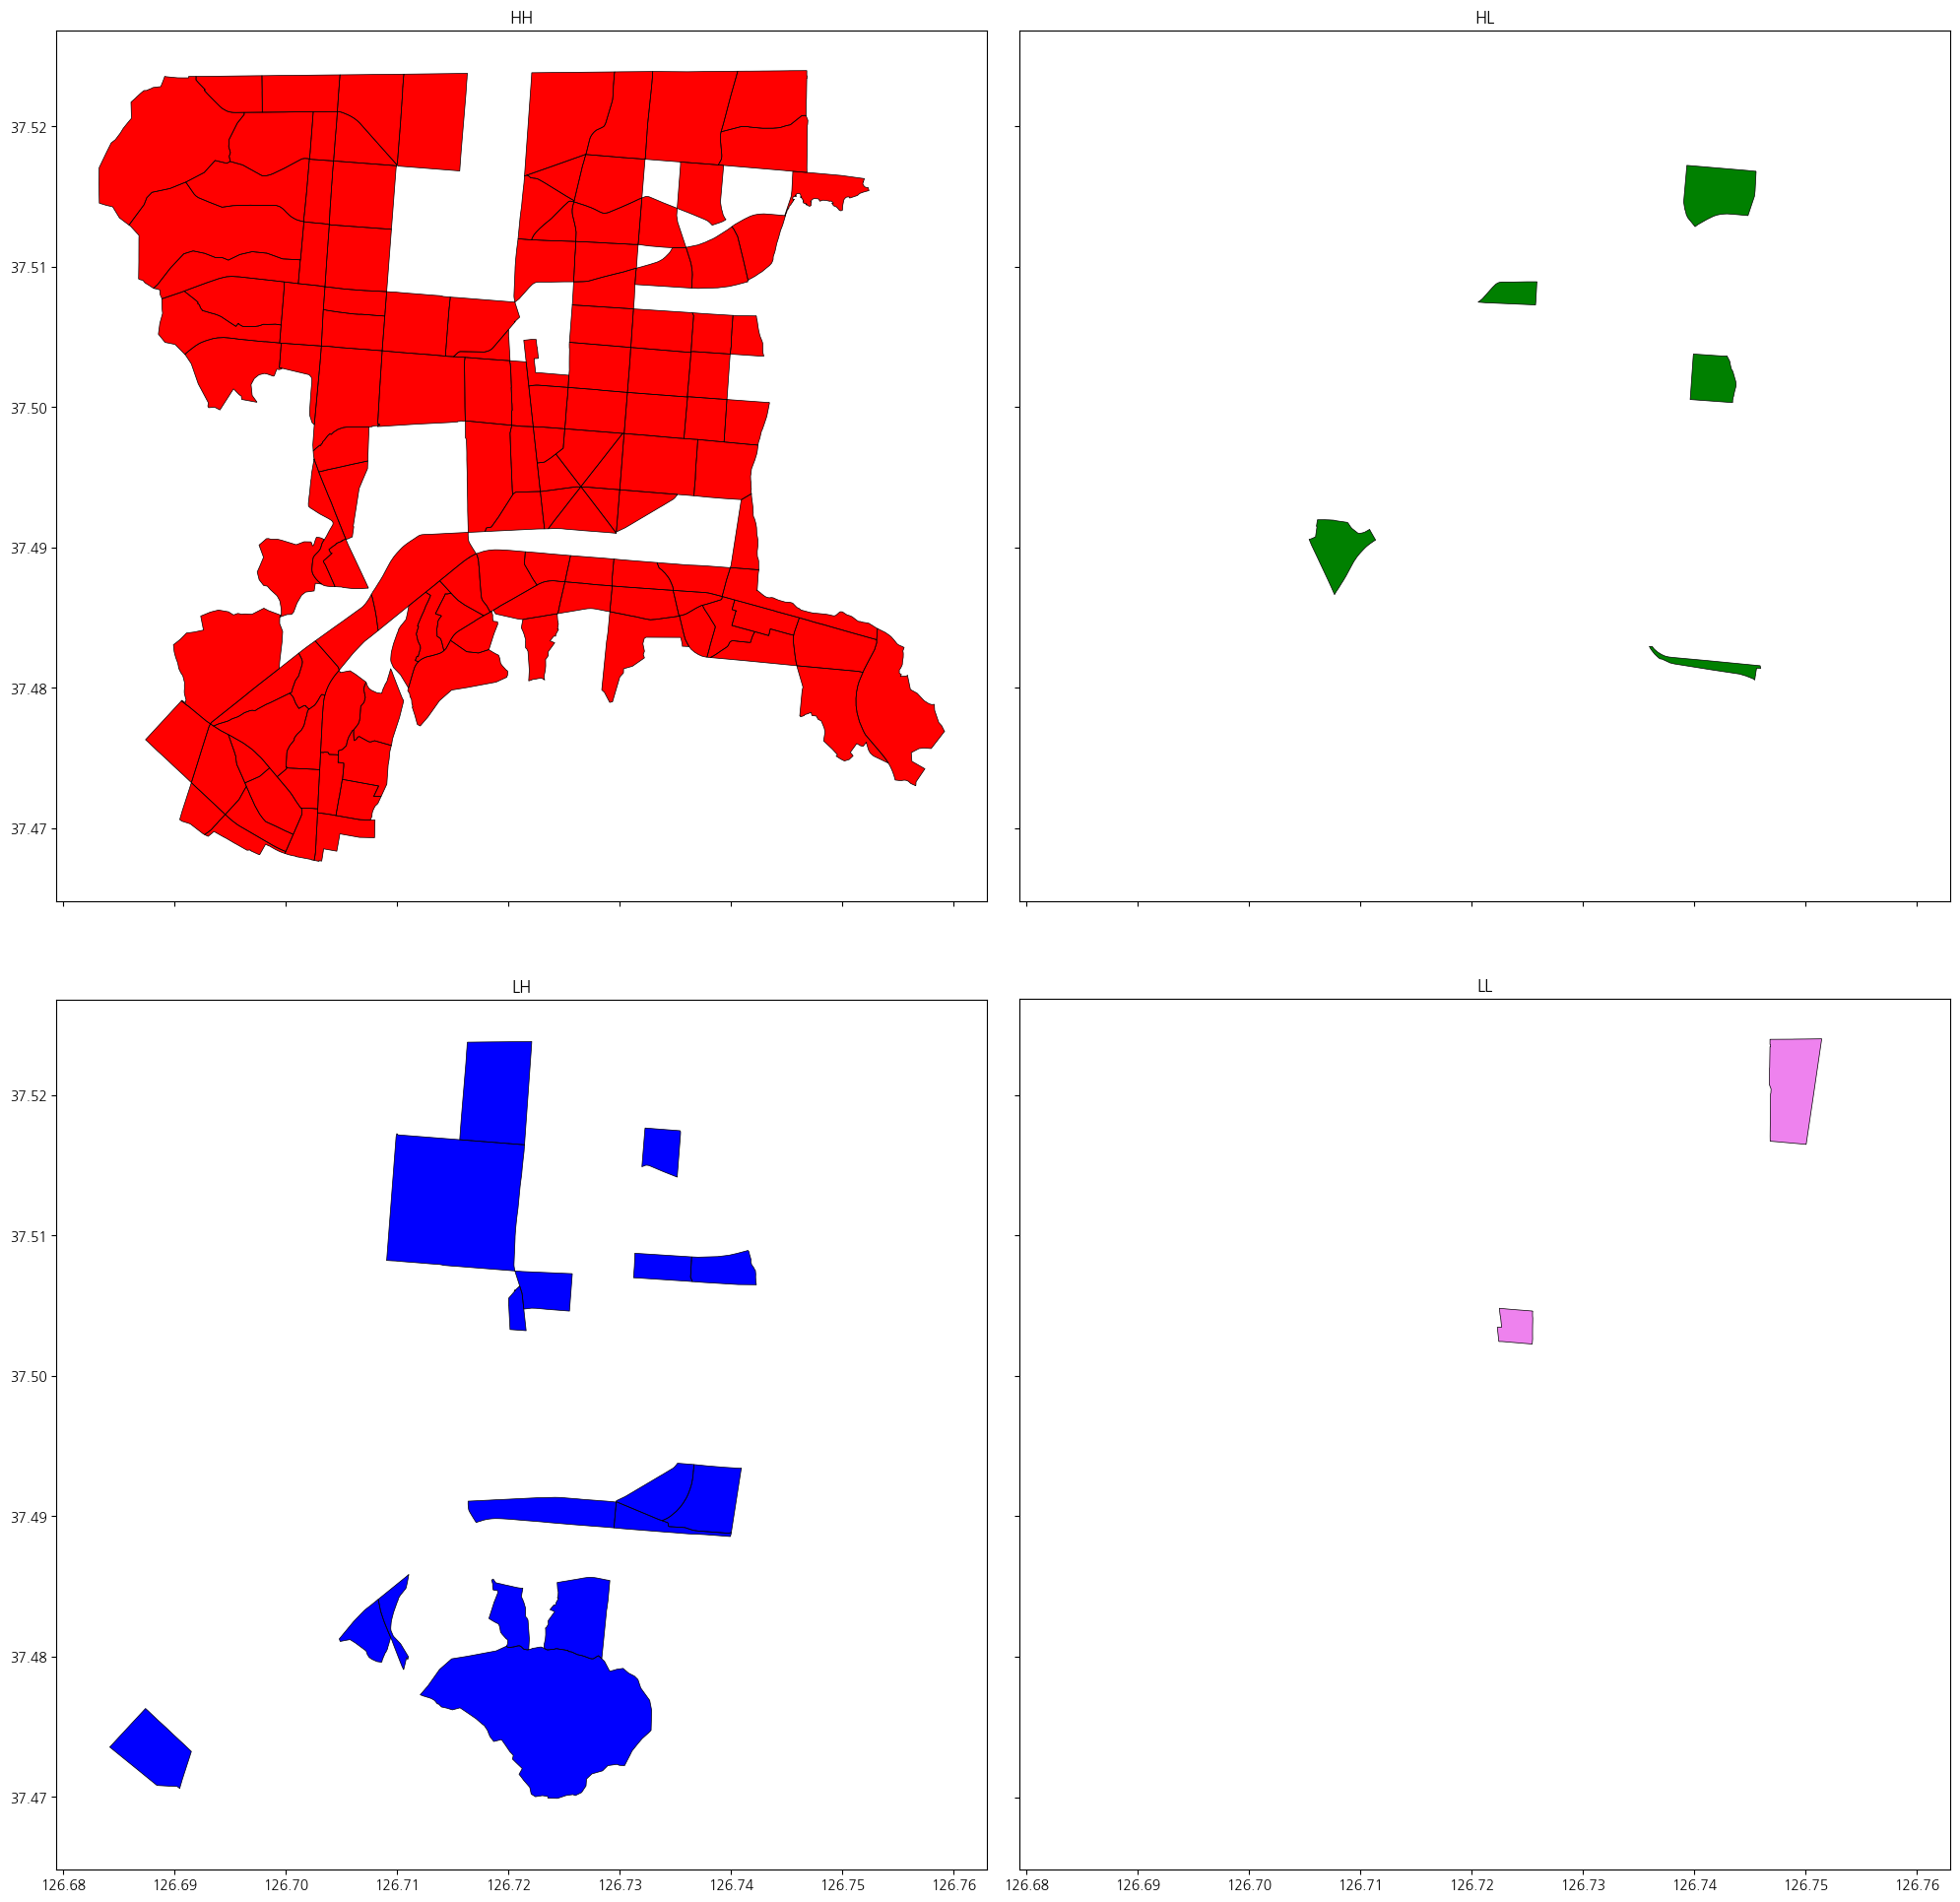

In [70]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(20,20))
colors = ['red','green','blue','violet']
#         HH, HL, LH, LL

for i in range(int(len(kind_list)/2)):
    for j in range(2):
        if len(kind_list[2*i+j]) != 0:          
            gdf = gpd.GeoDataFrame(kind_list[2*i+j])
            gdf.plot(ax=axes[i,j],color=colors[2*i+j])
            gdf.boundary.plot(ax=axes[i,j],color='black',linewidth=0.5)
            axes[i,j].set_title(title_list[2*i+j])

plt.tight_layout()
plt.show()

### 5.2.3 상관관계

#### 5.2.3.1 독립변수와 종속변수간의 상관계수

In [72]:
corr_df = ind_var.loc[:,optimal_feature].copy()
corr_df['평균폐업기간'] = clean_data.loc[:,'평균폐업기간']
corr_df = corr_df.corr()
ind = corr_df['평균폐업기간']
ind[abs(ind) > 0.1]

아파트 가구수              -0.149883
단독주택 비율               0.134932
평균최근접역거리              0.163982
(주거인구+직장인구) / 유동인구    0.127805
평균 도로 길이             -0.189219
도로길이고려_전체통합도          0.155315
점포밀도                 -0.150460
도로율                  -0.205265
상가밀도                 -0.150519
평균폐업기간                1.000000
Name: 평균폐업기간, dtype: float64

#### 5.2.2.2 상관 그래프

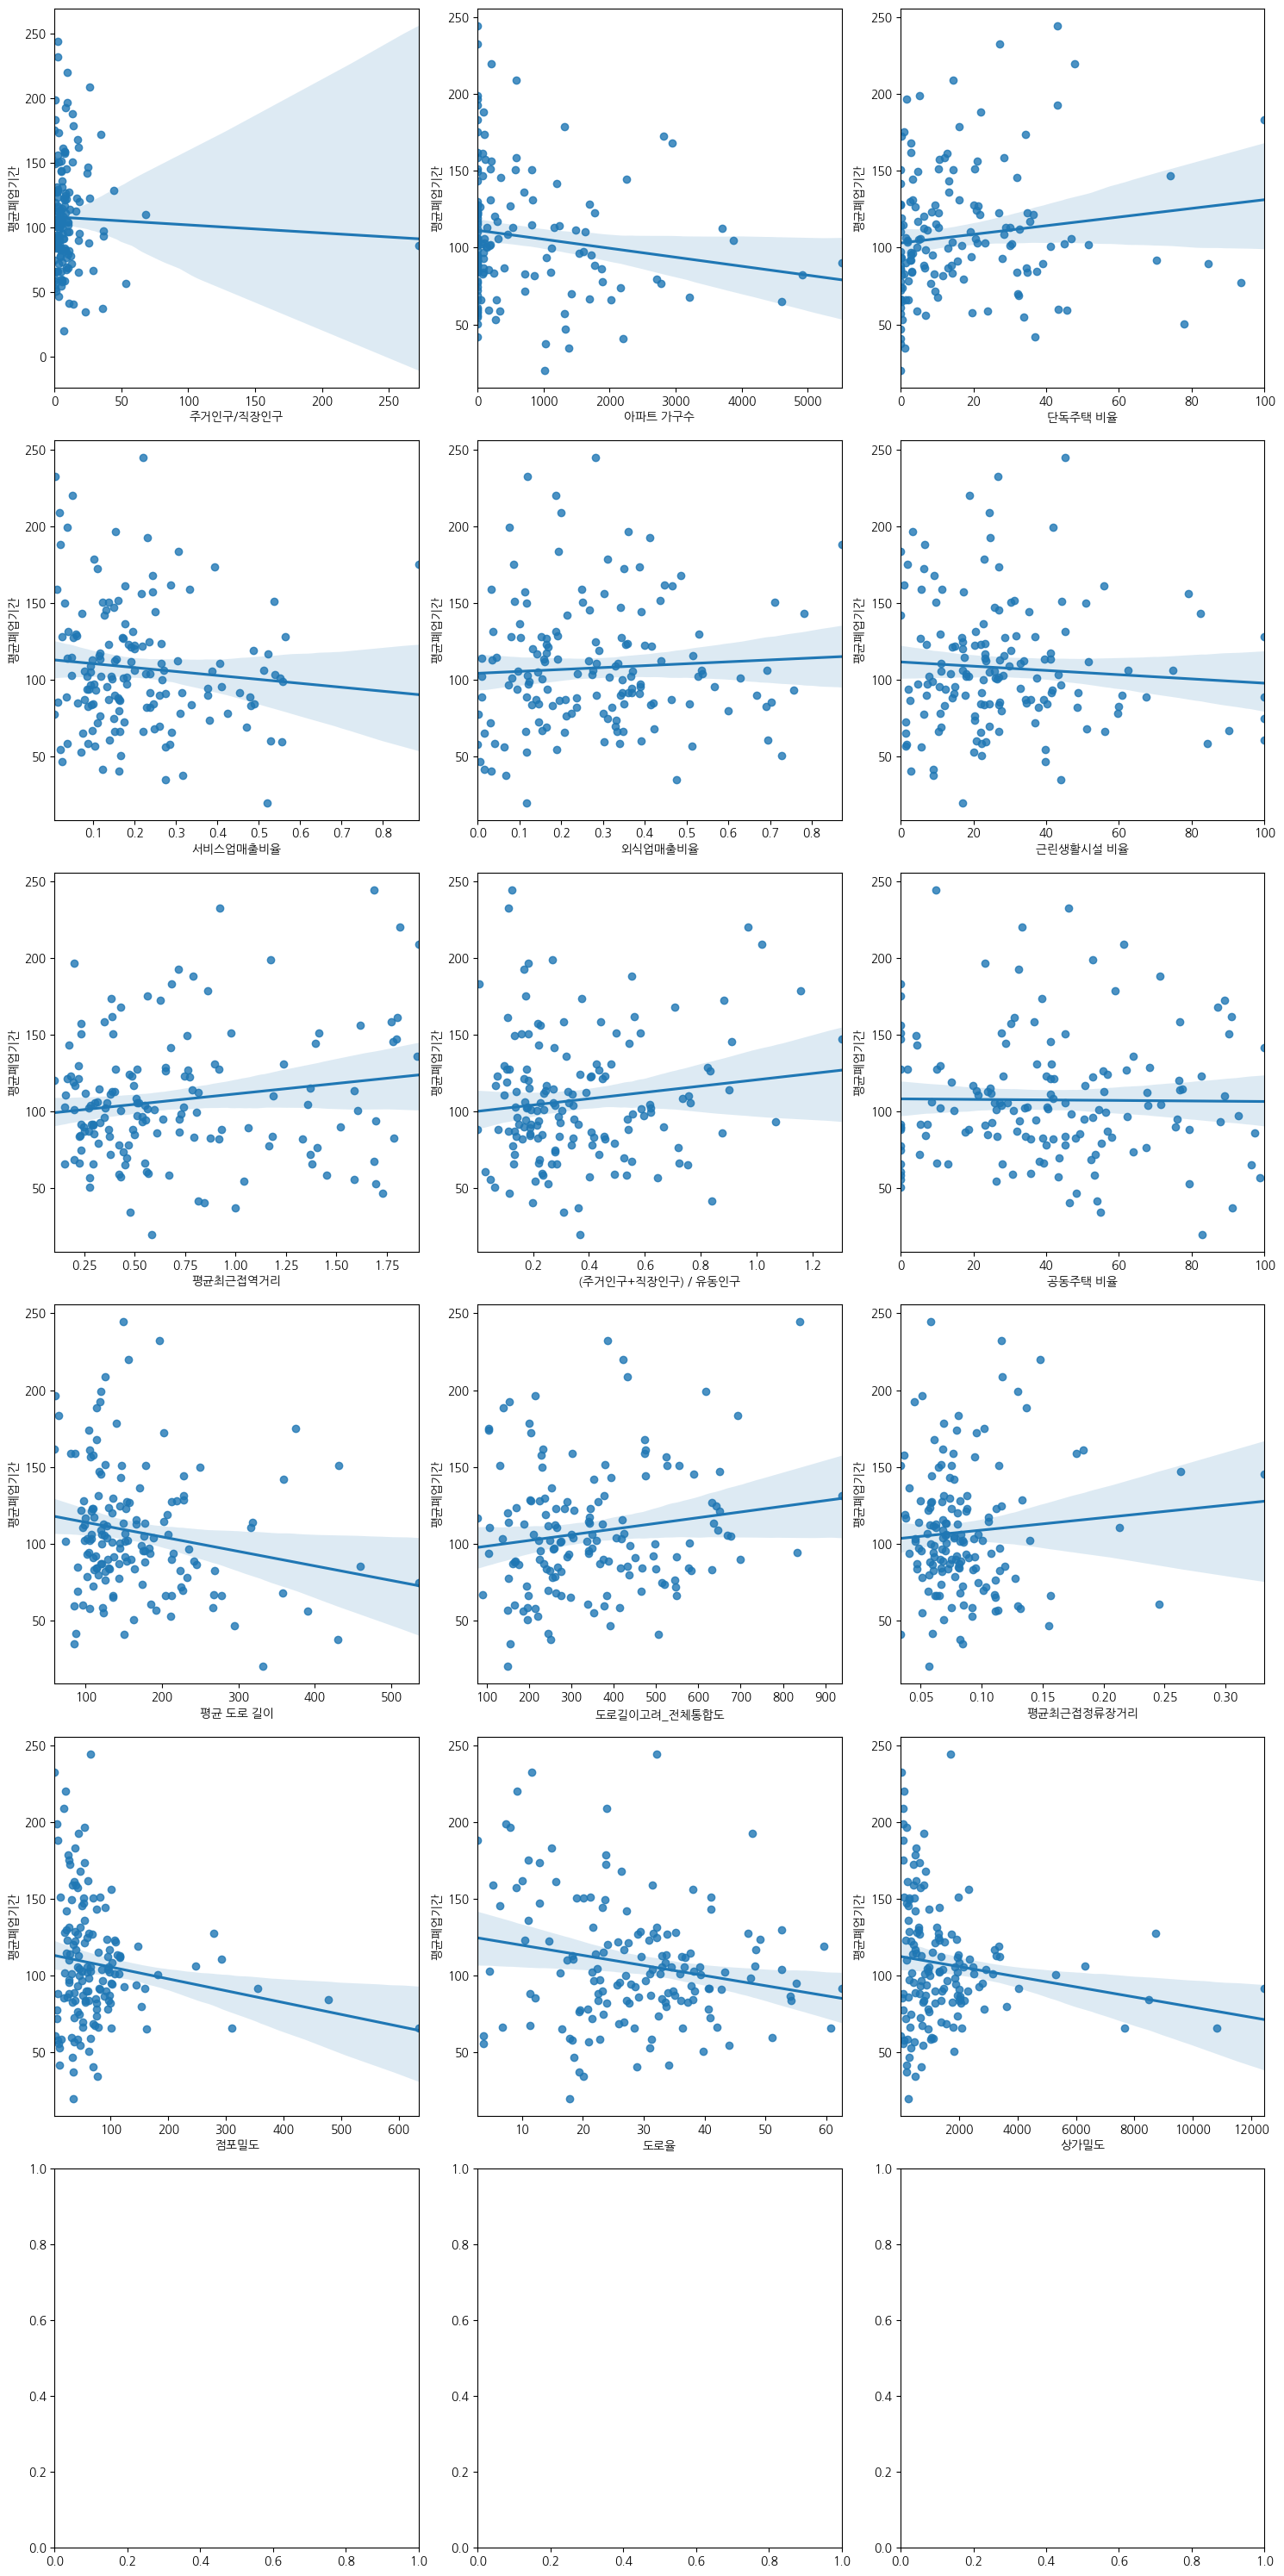

In [76]:
fig, axes = plt.subplots(nrows=int(len(optimal_feature)/3)+1,ncols=3,figsize=(15,30))

for idx, col in enumerate(optimal_feature):
    sns.regplot(x=col,y='평균폐업기간',data=clean_data,ax=axes[int(idx/3),idx % 3])

plt.tight_layout()
plt.show()

## 5.2 MODELING

In [79]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='exponential',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='exponential',spherical=True)
gwr_results = gwr_model.fit()

134.0


In [80]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 151
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         195075.801
Log-likelihood:                                                    -755.131
AIC:                                                               1542.263
AICc:                                                              1548.864
BIC:                                                             194398.468
R2:                                                                   0.220
Adj. R2:                                                              0.134

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [81]:
local_con_num = pd.Series(gwr_results.local_collinearity()[2].flatten())

In [82]:
local_con_num.sort_values()

121    26.435787
102    26.562052
120    26.574225
103    26.881607
124    27.024616
         ...    
25     33.254731
18     33.325822
21     33.496754
20     33.573536
19     33.654564
Length: 151, dtype: float64

In [ ]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+optimal_feature

In [84]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+optimal_feature
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
# gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균영업기간,bw_110,1110).csv',index=False,encoding='euc-kr')

### 5.2.1 회귀계수를 이용한 각 데이터들 간의 코사인 유사도

In [85]:
from scipy.spatial.distance import cdist
cos_df = pd.DataFrame(cdist(gwr_coef_df.iloc[:,:-3], gwr_coef_df.iloc[:,:-3], metric='cosine'),
                      columns = gwr_coef_df['BAS_ID'],
                      index = gwr_coef_df['BAS_ID'])
cos_df

BAS_ID,21300,21301,21302,21303,21304,21305,21306,21307,21308,21309,...,21449,21450,21451,21452,21453,21454,21455,21456,21457,21458
BAS_ID,,,,,,,,,,,,,,,,,,,,,
21300,0.000000,0.000078,0.000236,7.596945e-05,0.000173,0.000072,0.000029,0.000040,0.000067,0.000054,...,0.009814,0.009160,0.008845,0.007514,0.007556,0.007727,0.008785,0.003287,2.245154e-03,0.001819
21301,0.000078,0.000000,0.000091,2.337043e-05,0.000054,0.000024,0.000060,0.000144,0.000173,0.000062,...,0.011234,0.010564,0.010214,0.008834,0.008898,0.009098,0.010211,0.003995,2.643669e-03,0.002371
21302,0.000236,0.000091,0.000000,5.241391e-05,0.000010,0.000090,0.000254,0.000378,0.000402,0.000214,...,0.011396,0.010804,0.010440,0.009301,0.009450,0.009700,0.010662,0.005027,3.356482e-03,0.002880
21303,0.000076,0.000023,0.000052,1.110223e-16,0.000024,0.000011,0.000080,0.000154,0.000175,0.000063,...,0.010681,0.010064,0.009725,0.008471,0.008565,0.008778,0.009792,0.004151,2.804382e-03,0.002354
21304,0.000173,0.000054,0.000010,2.425754e-05,0.000000,0.000043,0.000175,0.000282,0.000299,0.000137,...,0.011360,0.010753,0.010396,0.009194,0.009318,0.009552,0.010550,0.004779,3.215750e-03,0.002784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21454,0.007727,0.009098,0.009700,8.777642e-03,0.009552,0.008886,0.008224,0.007571,0.007645,0.008499,...,0.000745,0.000493,0.000492,0.000053,0.000008,0.000000,0.000124,0.003493,4.770299e-03,0.002739
21455,0.008785,0.010211,0.010662,9.791508e-03,0.010550,0.009943,0.009360,0.008682,0.008750,0.009608,...,0.000277,0.000147,0.000162,0.000064,0.000098,0.000124,0.000000,0.004818,5.987651e-03,0.003585
21456,0.003287,0.003995,0.005027,4.150955e-03,0.004779,0.004061,0.003307,0.002945,0.003018,0.003599,...,0.006853,0.006050,0.005885,0.003894,0.003575,0.003493,0.004818,0.000000,7.622944e-04,0.000806


In [86]:
cos_sim_df = cos_df.apply(lambda x:1-x)

In [87]:
des_cos_sim_df = cos_sim_df.describe()
des_cos_sim_df.loc['min',:].agg(['min','max','mean'])

min     0.980189
max     0.994647
mean    0.987712
Name: min, dtype: float64

In [88]:
import math

math.degrees(np.arccos(0.984118))

10.225079558261976

In [89]:
des_cos_sim_df.loc['min',des_cos_sim_df.loc['min',:] == des_cos_sim_df.loc['min',:].min()]

BAS_ID
21320    0.980189
21383    0.980189
Name: min, dtype: float64

### 5.2.2 Scaling

#### 5.2.2.1 왜도, 첨도 확인

In [90]:
from scipy.stats import skew

skew_val = []
# kurtosis_val = []

for i, col in enumerate(optimal_feature):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    skew_val.append(skew(ind_var.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

skew_data = pd.DataFrame({'column name': optimal_feature,'skew':skew_val})
# kurtosis_data = pd.DataFrame({'column name':list(dX),'kurtosis':kurtosis_val})

In [91]:
skew_col = skew_data[skew_data['skew'].apply(lambda x : abs(x)) > 2]['column name']
# kurtosis_col = kurtosis_data[kurtosis_data['kurtosis'].apply(lambda x : abs(x)) > 3]['column name']

# skew_col
skew_col = skew_col.values

# kurtosis_col
# kurtosis_col = kurtosis_col.values
# 이 데이터들의 분포를 살펴보자.

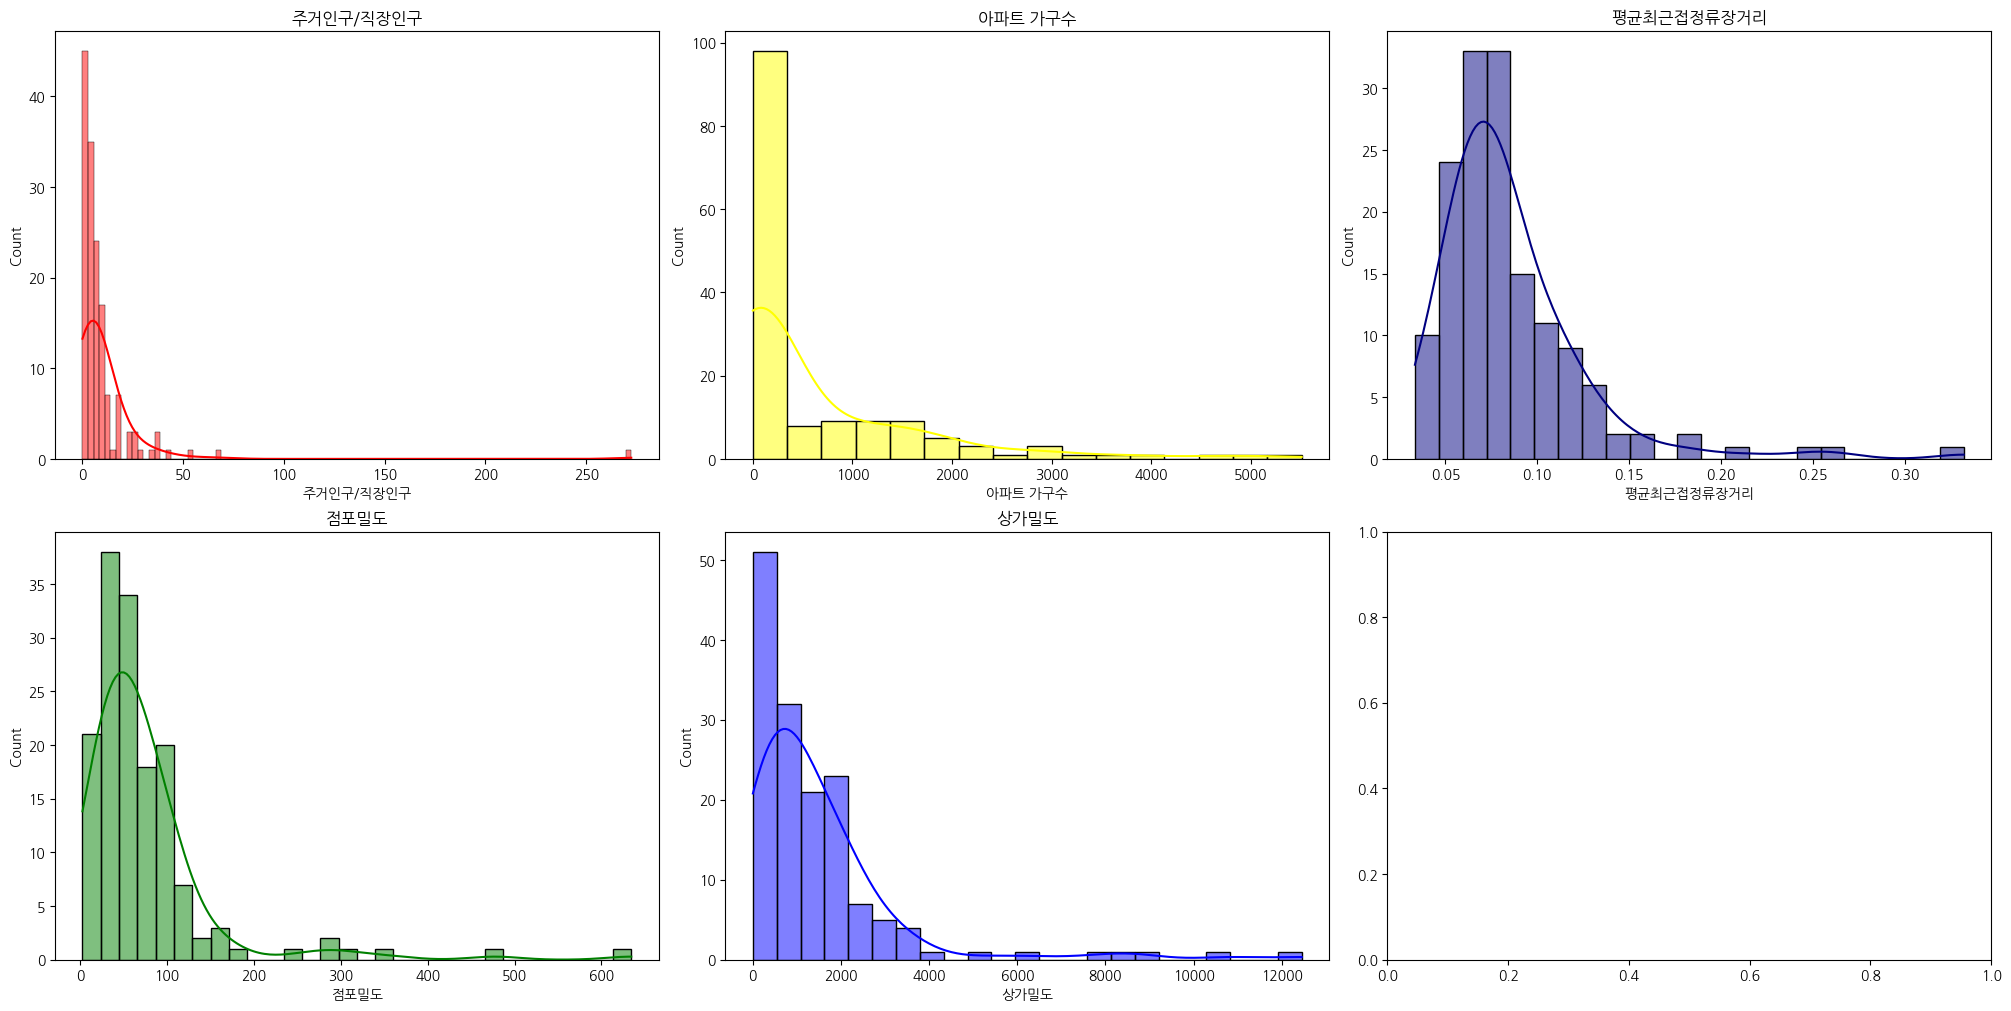

In [94]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,10),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=ind_var, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
         
plt.show()

In [95]:
# 해당 컬럼들은 log변환 진행.

# skew = 2, kurtosis=3

scaled_dX = ind_var.loc[:,optimal_feature].copy()
scaled_dX.loc[:,skew_col] = scaled_dX.loc[:,skew_col].apply(lambda x : np.log1p(x))
# scaled_dX.loc[:,robust_ok_col] = RobustScaler().fit_transform(scaled_dX.loc[:,robust_ok_col])

In [96]:
scaled_skew = []

for i, col in enumerate(list(skew_col)):
#     print('{0}. {1} : {2:.3f}'.format(i+1,col,skew(dX.loc[:,col])))
    scaled_skew.append(skew(scaled_dX.loc[:,col]))
#     kurtosis_val.append(kurtosis(dX.loc[:,col],fisher=True))

scaled_skew_data = pd.DataFrame({'column name': skew_col,'skew':scaled_skew})

display(skew_data[skew_data['column name'].isin(skew_col)])
display(scaled_skew_data)

,column name,skew
0,주거인구/직장인구,9.117528
1,아파트 가구수,2.294927
11,평균최근접정류장거리,2.729858
12,점포밀도,3.963844
14,상가밀도,3.367671


,column name,skew
0,주거인구/직장인구,0.314511
1,아파트 가구수,-0.034807
2,평균최근접정류장거리,2.450884
3,점포밀도,-0.324121
4,상가밀도,-0.745321


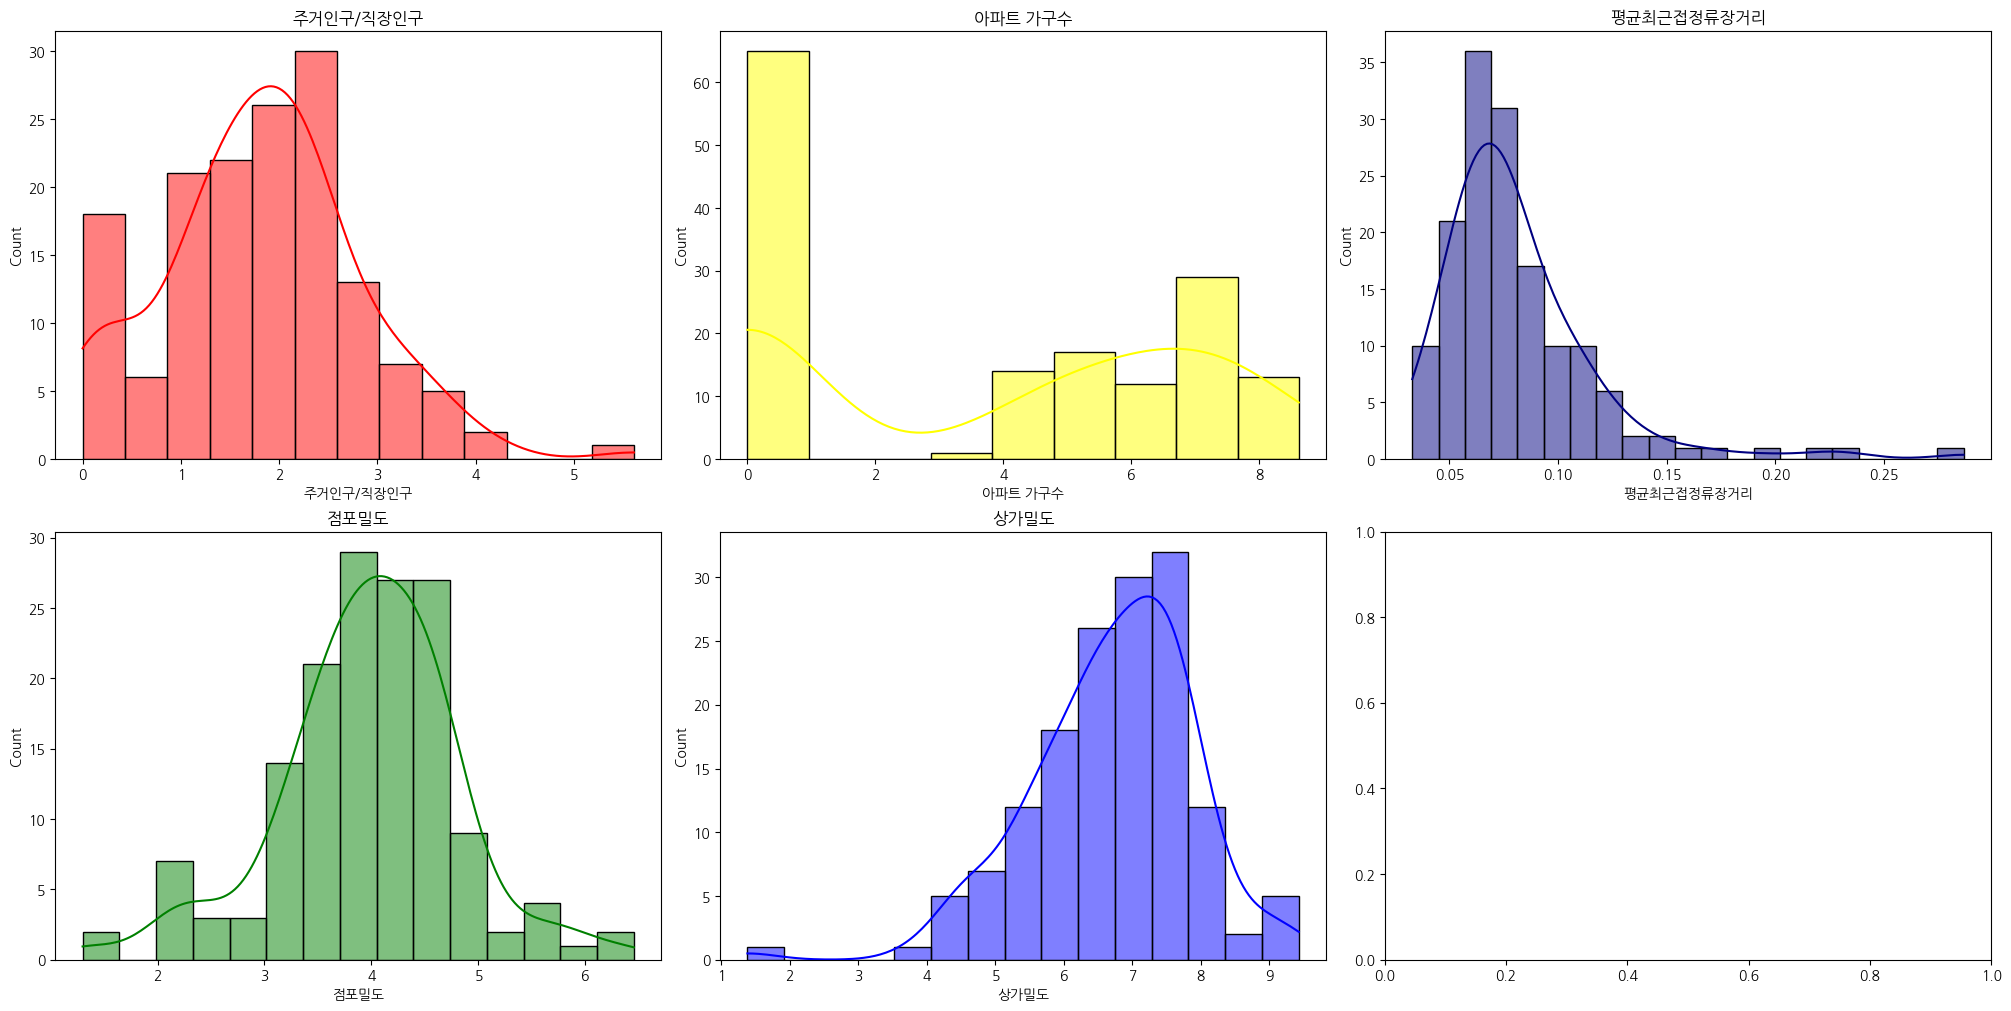

In [97]:
fig, axes = plt.subplots((int(len(skew_col)/3)+1),3,figsize=(20,10),constrained_layout=True)
color = ['red','yellow','navy','green','blue','magenta','violet','skyblue']

for i in range(int(len(skew_col)/3)+1):
    for j in range(3):
        if (3*i+j) == len(skew_col):
            break
        
        sns.histplot(ax=axes[i,j], data=scaled_dX, x=skew_col[(3*i+j)], kde=True,color=color[(3*i+j) % 8])
        axes[i,j].set_title(skew_col[3*i+j])
        
plt.show()

#### 5.2.2.2 Remodeling

In [115]:
# 스케일링된 독립변수 설정.
s_X = scaled_dX.values

# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='exponential',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='exponential',spherical=True)
gwr_results = gwr_model.fit()

98.0


In [116]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 151
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         194045.459
Log-likelihood:                                                    -754.732
AIC:                                                               1541.463
AICc:                                                              1548.065
BIC:                                                             193368.126
R2:                                                                   0.225
Adj. R2:                                                              0.138

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.2.3 MinMaxScaling
- 교차검증 시 안했을 때의 best score와 같았음.

In [117]:
scaler = MinMaxScaler()
mm_scaled_dX = scaled_dX.copy()
mm_scaled_dX = pd.DataFrame(scaler.fit_transform(mm_scaled_dX),columns=mm_scaled_dX.columns)
s_X = mm_scaled_dX.values

#### 5.2.2.4 Remodeling

In [118]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='exponential',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='exponential',spherical=True)
gwr_results = gwr_model.fit()

98.0


In [119]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 151
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         194045.459
Log-likelihood:                                                    -754.732
AIC:                                                               1541.463
AICc:                                                              1548.065
BIC:                                                             193368.126
R2:                                                                   0.225
Adj. R2:                                                              0.138

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

#### 5.2.2.5 Standard Scaling

In [120]:
scaler = StandardScaler()
ss_scaled_dX = scaled_dX.copy()
ss_scaled_dX = pd.DataFrame(scaler.fit_transform(ss_scaled_dX),columns=ss_scaled_dX.columns)
s_X = ss_scaled_dX.values

In [121]:
# 스케일링 후 다중공선성 제거

vif_result = RFE(ss_scaled_dX)
scaled_optimal_feature = vif_result['features'].values.tolist()
scaled_optimal_feature

['외식업매출비율',
 '서비스업매출비율',
 '도로길이고려_전체통합도',
 '평균최근접역거리',
 '평균최근접정류장거리',
 '평균 도로 길이',
 '단독주택 비율',
 '(주거인구+직장인구) / 유동인구',
 '근린생활시설 비율',
 '아파트 가구수',
 '도로율',
 '주거인구/직장인구',
 '공동주택 비율',
 '점포밀도',
 '상가밀도']

#### 5.2.2.6 Remodeling

In [122]:
# 모델 생성
gwr_selector = Sel_BW(s_coords, s_y2, s_X,kernel='exponential',spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='exponential',spherical=True)
gwr_results = gwr_model.fit()

98.0


In [123]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 151
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                         194045.459
Log-likelihood:                                                    -754.732
AIC:                                                               1541.463
AICc:                                                              1548.065
BIC:                                                             193368.126
R2:                                                                   0.225
Adj. R2:                                                              0.138

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### 5.2.3 교차검증

In [ ]:
def cross_validation_gwr(lX, ly, kernel,ran_state):
    train_aic = np.zeros(5)
    train_ll = np.zeros(5)
    train_r2 = np.zeros(5)
    train_adj_r2 = np.zeros(5)
    residual = []

    cv = KFold(5, shuffle=True, random_state=ran_state)

    for i, (idx_train, idx_test) in enumerate(cv.split(X = lX, y = ly)):
    
#         print('====================== FOLD {} ======================'.format(i))
        # train, test split
        local_res = np.zeros(158)
        local_X_train, local_y_train = lX[idx_train], ly[idx_train]
        local_u_train = clean_data.iloc[idx_train]['x']
        local_v_train = clean_data.iloc[idx_train]['y']
        local_train_coords = list(zip(local_u_train,local_v_train))
    
        local_X_test, local_y_test = lX[idx_test], ly[idx_test]
        local_u_test = clean_data.iloc[idx_test]['x']
        local_v_test = clean_data.iloc[idx_test]['y']
        local_test_coords = list(zip(local_u_test,local_v_test))
    
        # 모델 생성
        gwr_selector = Sel_BW(local_train_coords, local_y_train, local_X_train,kernel=kernel,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
#         print('BAND WIDTH : {}'.format(gwr_bw))
        gwr_model = GWR(local_train_coords, local_y_train, local_X_train, gwr_bw,kernel=kernel,spherical=True)
        gwr_results = gwr_model.fit()
        
        # Prediction
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        pred_results = gwr_model.predict(np.array(local_test_coords), local_X_test, scale, residuals)
        pred = pred_results.predictions.flatten()
        
        # AIC
        train_aic[i] = gwr_results.aic
    
        # R2 스코어
        train_r2[i] = gwr_results.R2
        
        # Adj. R2 스코어
        train_adj_r2[i] = gwr_results.adj_R2
#         test_r2[i] = r2_score(local_y_test,pred)
        
        # Log-Likelihood
        train_ll[i] = gwr_results.llf
#         residual.append(local_y_test.flatten()-pred)
#         train_rmse[i] = np.sqrt(gwr_results.)
#         test_rmse[i] = np.sqrt(mean_squared_error(local_y_test,pred))
    
#         print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2[i], test_r2[i]))
# #         print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse[i], test_rmse[i]))
#         print("TRAIN AIC : {:.8f}".format(train_aic[i]))
#         print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll[i]))
    
#     print('\n===================== 평균 결과 ======================')
#     print('TRAIN R2 : {:.8f}, TEST R2 : {:.8f}'.format(train_r2.mean(), test_r2.mean()))
# #     print('TRAIN RMSE : {:.8f}, TEST RMSE : {:.8f}'.format(train_rmse.mean(), test_rmse.mean()))
#     print("TRAIN AIC : {:.8f}".format(train_aic.mean()))
#     print("TRAIN LOG-LIKELIHOOD : {:.8f}".format(train_ll.mean()))
    
    return train_aic.mean(), train_ll.mean(), train_r2.mean(), train_adj_r2.mean()
# , residual

# cross_validation_gwr(s_X, s_y1)

### 5.2.4 Feature Selection

In [ ]:
def search_best_model(kernel,ind_val,ran_state,i):
    flag = True
    min_aic = float('inf')
    max_ll = float('-inf')
    max_r2 = float('-inf')
    adj_r2 = ''
    col_list = list(ind_val.columns)
    drop_col = []

    # flag가 False라면 탈출
    while flag :  
        # 조건 초기화, 평가 치표가 업데이트 된 흔적이 있으면 다시 진입할 것이다.
        flag = False 
    
        # 사용 컬럼 업데이트
#         print('COL LIST COUNT : {}'.format(len(col_list)-len(drop_col)))
#         print('DROP COLUMN LIST COUNT : {}'.format(len(drop_col)))
        col_list = list(set(col_list) - set(drop_col))
        drop_col.clear()
    
        # 사용할 독립변수 업데이트
        temp_dX = ind_val.loc[:,col_list]
    
        # 컬럼 하나씩 지우면서 평가지표 확인
#         for col in tqdm(col_list):
        for col in col_list:
            local_X = temp_dX.drop(col,axis=1).values
            new_aic, new_ll, new_r2, new_adj_r2 = cross_validation_gwr(local_X, s_y1,kernel,ran_state)

            # 새로운 aic는 기존의 aic보다 작고, 새로운 ll은 기존의 ll보다 큰가?(AND 조건이어야 함.)
            if (new_aic < min_aic) & (new_ll > max_ll) & (max_r2 < new_r2):
                min_aic = new_aic
                max_ll = new_ll
                max_r2 = new_r2
                adj_r2 = new_adj_r2
                drop_col.append(col)
                flag = True
                print('========================= NEW VALIDATION =========================')
                print('NEW MAX R2 : {:.8f}'.format(max_r2))
                print('NEW MIN AIC : {:.8f}'.format(min_aic))
                print('NEW MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    
    print('========================= RESULT =========================')
    print('KERNEL : {}'.format(kernel))
    print('RANDOM STATE : {}'.format(ran_state))
    print('DATASET NUMBER : {}'.format(i))
    print('MAX R2 : {:.8f}'.format(max_r2))
    print('Adj. R2 : {:.8f}'.format(adj_r2))
    print('MIN AIC : {:.8f}'.format(min_aic))
    print('MAX LOG-LIKELIHOOD : {:.8f}'.format(max_ll))
    print('COLUMN COUNT : {}'.format(len(col_list)))
#     print('COLUMN : {}'.format(col_list))

    
    result = pd.DataFrame({'KERNEL':kernel,'RANDOM STATE':ran_state,'DATASET NUMBER':i,'R2':max_r2
                           ,'Adj. R2':adj_r2,'AIC':min_aic,'LOG LIKELIHOOD':max_ll
                           ,'COLUMN COUNT':len(col_list),'COLUMN':[col_list]})
    
    return result

### 5.2.5 Optimal Bandwidth

In [ ]:
store_path = '../data/전처리 파일/가중치행렬(gaussian)'
bandwidth = []
aicc = []
r2 = []
ll = []
start = 20
end = 50
step = 2

for bw in range(start,end,step):
    gwr_bw = bw
    gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel='gaussian',spherical=True)
    gwr_results = gwr_model.fit()
    print('='*30+' RESULT '+'='*30)
    print('Bandwidth : {}, R2 : {:3f}, Log-Likelihood : {:3f}, AICc : {:.3f}'.format(bw,gwr_results.R2,
                                                                              gwr_results.llf,gwr_results.aicc))
    bandwidth.append(bw)
    aicc.append(gwr_results.aicc)
    r2.append(gwr_results.R2)
    ll.append(gwr_results.llf)
#     p_val = spatial_variability(gwr_model,bw,n_iters=1000)
#     print('유의 확률 30% : {}'.format(len(p_val[p_val < 0.3])))
    
#     gwr_coef_df = pd.DataFrame(gwr_results.params)
#     gwr_coef_df.columns = ['intercept']+list(clean_data.iloc[:,ind_var_col].columns)
#     gwr_coef_df['x'] = u
#     gwr_coef_df['y'] = v
#     gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
#     gwr_coef_df.to_csv('../data/전처리 파일/회귀계수/BW별 회귀계수(AICc)/GWR 회귀계수(평균영업기간,bw_'+str(bw)+',1111).csv',index=False,encoding='euc-kr')
    weight = pd.DataFrame(gwr_results.W,columns=clean_data['BAS_ID'],index=clean_data['BAS_ID'])
    weight.to_csv(os.path.join(store_path,'weight('+str(bw)+',gaussian,20_50).csv'),encoding='euc-kr')

aicc_by_bw = pd.DataFrame({'band width':bandwidth,'R2':r2,'Log-Likelihood':ll,'AICc':aicc})

In [ ]:
# Band width에 따른 AICc 그래프
sns.scatterplot(x=aicc_by_bw['band width'],y=aicc_by_bw['AICc'],color='magenta')
plt.show()

In [ ]:
diff_aicc = pd.DataFrame({'Interval':range(0,len(aicc_by_bw['AICc'])-1),'diff':abs(np.diff(aicc_by_bw['AICc']))})

In [ ]:
# AICc 감소폭 그래프

sns.scatterplot(x=diff_aicc['Interval'],y=diff_aicc['diff'],color='violet')
plt.show()

### 5.2.6 Column별 회귀계수 분포

In [ ]:
coef_df_list = [] # bw별 회귀계수 data frame list, tuple로 저장할것(bandwidth, coef_df)
coef_df_by_col_list = [] # column별 회귀계수 dataframe list
start = 80
end = 130
step = 2

# bw별로 회귀계수 dataframe 생성
for bw in range(start,end,step):
    gwr_bw = bw
    gwr_model = GWR(s_coords, s_y2, s_X, gwr_bw,kernel='exponential',spherical=True)
    gwr_results = gwr_model.fit()
    gwr_coef_df = pd.DataFrame(gwr_results.params)
    gwr_coef_df.columns = ['intercept']+optimal_feature
    gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
    coef_df_list.append(tuple((bw,gwr_coef_df)))

# column별 회귀계수 dataframe list 생성
for i in range(len(optimal_feature)):
    coef_df_by_col_list.append(pd.DataFrame(columns=range(start,end,step),index=clean_data['BAS_ID']))

# loop 돌면서 각 컬럼별, bw별 dataframe을 생성
for bw,coef_df in coef_df_list:
    for i in range(len(optimal_feature)):
        coef_df_by_col_list[i].loc[:,bw] = coef_df.iloc[:,i].values

In [ ]:
len(coef_df_by_col_list)

15

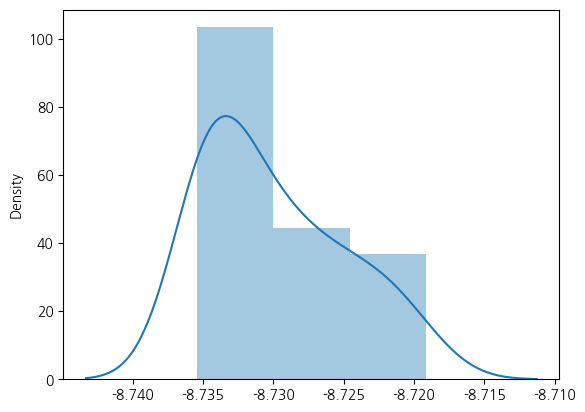

In [ ]:
# 개별공시지가 회귀계수의 분포를 살펴보자
col_name = '단독주택 비율'
col_idx = optimal_feature.index(col_name)
target = coef_df_by_col_list[col_idx]
bas_id = '21300'
# target.loc[bas_id].describe()
sns.distplot(x=target.loc[bas_id])
plt.show()

In [ ]:
bas_id_list = list(clean_data['BAS_ID'])
store_path = '../data/전처리 파일/회귀계수/Column별'

for col in tqdm(list(dX)): 
    if '/' in col:
        col_path = col.replace('/',',')
    else:
        col_path = col
        
    if not os.path.isdir(os.path.join(store_path,col_path)):
        os.mkdir(os.path.join(store_path,col_path))
    
    col_idx = dX.columns.values.tolist().index(col)+1
    target = coef_df_by_col_list[col_idx]
    
    for bas_id in bas_id_list:
        # min값과 max값의 부호가 다른 경우에만 그래프 저장 실행
        if (target.loc[bas_id].min()*target.loc[bas_id].max()) > 0:
            continue
            
        sns.histplot(x=target.loc[bas_id], kde=True,color='violet')
        plt.title(bas_id)
        plt.savefig(os.path.join(store_path,col_path,bas_id+'.png'))
        plt.cla()

NameError: name 'dX' is not defined

In [ ]:
dir_list = os.listdir(store_path)
count = []
for dir_name in dir_list:
    file_num = len(os.listdir(os.path.join(store_path,dir_name)))
    count.append(file_num)
#     print('{} : {}'.format(dir_name,file_num))
    
count_df = pd.Series(count,index=dir_list)
count_df.sort_values(ascending=False)

## 5.3 Dataset별 GWR Modeling

In [ ]:
# 1. Raw Data
rd_X = clean_data.iloc[:,ind_var_col]

# 2. Raw Data에서 다중공선성 제거
remove_high_vif_X = clean_data.loc[:,optimal_feature]

# 3. skew가 2 이상인 데이터에 대해서 log1p를 적용한 데이터셋+standard scaler
scaled_X = ss_scaled_dX

# 4. skew가 2 이상인 데이터에 대해서 log1p를 적용하고 다중공선성을 제거한 데이터셋
remove_high_vif_scaled_X = ss_scaled_dX.loc[:,scaled_optimal_feature]

# # 5. Raw Data에서 매출월평균변화량만 제거
# rm_avg_X = clean_data.iloc[:,ind_var_col].drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

# # 6.skew가 2 이상인 데이터에 대해서 log1p를 적용하고 +standard~ 매출월평균변화량만 제거
# scaled_rm_avg_X = ss_scaled_dX.drop(['서비스업매출월평균변화량','소매업매출월평균변화량','외식업매출월평균변화량'],axis=1)

ind_dataset = [rd_X,remove_high_vif_X,scaled_X,remove_high_vif_scaled_X]
kernel = ['gaussian','exponential','bisquare']

aic = []
ll = []
r2 = []
adj_r2 = []
ker = []
dataset_idx = []

for func in kernel:
    for i,s_X in enumerate(ind_dataset):
        s_X = s_X.values
        # 모델 생성
        gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=func,spherical=True)
        gwr_bw = gwr_selector.search(bw_min=2)
        gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=func,spherical=True)
        gwr_results = gwr_model.fit()
    
        # 평가 지표
        aic.append(gwr_results.aic)
        ll.append(gwr_results.llf)
        r2.append(gwr_results.R2)
        adj_r2.append(gwr_results.adj_R2)
        ker.append(func)
        dataset_idx.append(i)

valid_result = pd.DataFrame({'Data Number':dataset_idx,'Kernel':ker,'R2':r2,'Adj. R2':adj_r2
                             ,'AIC':aic,'Log-Likelihood':ll})

In [ ]:
valid_result.sort_values(by='Adj. R2',ascending=False)

### 5.3.1 Feature Selection

In [ ]:
import time

list_df = [ind_var.loc[:,optimal_feature]]
kernel = ['f2','bisquare']
random_state = [10]

conclusion = pd.DataFrame()
count = 0
start_time = time.time()

for k in kernel:
    for i, df in enumerate(list_df):
        for rs in random_state:
            result = search_best_model(k,df,rs,i)
            conclusion= pd.concat([conclusion,result],axis=0,ignore_index=True)
            count += 1
            print('진행률 : {0:.2f}%, 소요시간 : {1:.2f}분'.format(count/(len(kernel)*len(list_df)*len(random_state))*100,(time.time()-start_time)/60))

conclusion.head()

In [ ]:
condition = ((conclusion['AIC'].min() == conclusion['AIC']) | (conclusion['LOG LIKELIHOOD'].max() == conclusion['LOG LIKELIHOOD']) 
             | (conclusion['R2'] == conclusion['R2'].max()))
conclusion[condition]

In [ ]:
conclusion.sort_values(by='R2',ascending=False).head()

In [ ]:
conclusion.loc[1,'COLUMN']

#### 5.3.1.1 Remodeling

In [ ]:
idx = 2
kernel = 'bisquare'
# conclusion.iloc[idx]['KERNEL']
col = conclusion.iloc[idx]['COLUMN']

# s_X = ind_dataset[idx].loc[:,col].values
s_X = ind_dataset[conclusion.iloc[idx]['DATASET NUMBER']].loc[:,col].values

In [ ]:
#Calibrate GWR model
# 평균영업기간

gwr_selector = Sel_BW(s_coords, s_y1, s_X,kernel=kernel,spherical=True)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_model = GWR(s_coords, s_y1, s_X, gwr_bw,kernel=kernel,spherical=True)
gwr_results = gwr_model.fit()

In [ ]:
gwr_results.summary()

In [ ]:
gwr_coef_df = pd.DataFrame(gwr_results.params)
gwr_coef_df.columns = ['intercept']+col
gwr_coef_df['x'] = u
gwr_coef_df['y'] = v
gwr_coef_df['BAS_ID'] = clean_data['BAS_ID']
gwr_coef_df.to_csv('../data/전처리 파일/GWR 회귀계수(평균영업기간(자동차제거,null유지),1108).csv',index=False,encoding='euc-kr')

In [ ]:
conclusion.to_csv('../data/최적모델평가지표(평균영업기간,자동차제거,매출log,null유지,절사평균).csv',encoding='euc-kr',index=False)

# 7. T-검정
- 예측값과 실제값의 평균이 서로 차이가 있는지 검정한다.

In [ ]:
# 필요 데이터셋 생성
s_X = pd.concat([dX.loc[:,col],clean_data.loc[:,['x','y']]],axis=1)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(s_X, s_y1, test_size=0.2, shuffle=True,random_state=34)

# train 좌표 생성
u_train = X_train.loc[:,'x']
v_train = X_train.loc[:,'y']
train_coords = list(zip(u_train,v_train))

# test 좌표 생성
u_test = X_test.loc[:,'x']
v_test = X_test.loc[:,'y']
test_coords = list(zip(u_test,v_test))

# train, test set 독립변수 리스트에서 좌표 제거
X_train.drop(['x','y'],axis=1,inplace=True)
X_test.drop(['x','y'],axis=1,inplace=True)

X_train = X_train.values
X_test = X_test.values

# 모델 생성
gwr_selector = Sel_BW(train_coords, y_train, X_train,kernel='gaussian')
gwr_bw = gwr_selector.search(bw_min=2)

print('BAND WIDTH : {}'.format(gwr_bw))
gwr_model = GWR(train_coords, y_train, X_train, gwr_bw,kernel='gaussian')
gwr_results = gwr_model.fit()
    
# Prediction
scale = gwr_results.scale
residuals = gwr_results.resid_response
pred_results = gwr_model.predict(np.array(test_coords), X_test, scale, residuals)
pred = pred_results.predictions.flatten() 

## 7.1 정규성 검증

In [ ]:
test = stats.shapiro(y_test)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 y_test는 정규성을 따른다.

In [ ]:
test = stats.shapiro(pred)
print('검정통계량 : {0}\np-value : {1}'.format(test[0],test[1]))

# 유의수준 0.05에서 귀무가설을 기각하고 대립가설을 채택
# 따라서 정규성을 띄지 않는다.

In [ ]:
df = pd.DataFrame({'pred':pred,'test':y_test.flatten()})
df.describe()

In [ ]:
# 독립이표본 t-test
result = stats.ttest_ind(pred, y_test, equal_var=False)
print('p-value : {:.8f}'.format(result[1][0]))

# 유의 수준 0.05에서 귀무가설을 기각할 수 없으므로 두 집단 간의 평균 차이가 없다고 말할 수 있다.

In [ ]:
ax = plt.subplot()
sns.distplot(y_test,ax=ax,color='red',label='test set',hist=False)
sns.distplot(pred,ax=ax,color='violet',label='prediction',hist=False)
ax.set_title('Prediction vs Test Set')
ax.legend()
plt.show()